# 第五組 - 針對PTT麥當勞熱門事件進行情緒分析
- 動機說明
    - 麥當勞近幾年有發生一些社會議題，包括性騷擾事件、聯名商品的爭議，另外也會不斷地推出新品、優惠活動，因此可以從文字雲和情緒分析來得知正向與負向的情緒狀況與討論議題。
- 困難與解決方法
    - 主題要符合適合文字分析的內容，因此小組討論每人實作一個主題（夜夜秀、GU、魷魚遊戲、輝達、速食愛情、進擊的巨人、資工所、麥當勞），再投票決定要選擇哪一個內容，最後選擇麥當勞做為本組的主題。
    - 分析文字雲停用字時需要思考應該刪除什麼內容，要判斷當時的與論狀況，可以比較好分析出詞語出現的意義。
    - Tarflow 沒有速食板看板，因此本組直接爬了全部板的文章，在情緒分析(二)時，資料因過於雜亂因此我們重新用 Python 對 PTT 速食板做爬蟲。(50頁資料，999筆資料)

## 大綱
1. 文字雲分析
    - 1.1 資料介紹
    - 1.2 中文斷句、斷詞
    - 1.3 計算去除停用字及更新字典前的詞頻
    - 1.4 移除停用字
    - 1.5 更新斷詞及停用字詞典
    - 1.6 比較清理前後的文字雲
2. 情緒分析(一)
    - 2.1 準備LIWC情緒字典
    - 2.2 情緒字典與斷詞結果進行合併
    - 2.3 正負向情緒詞彙頻率折線圖圖
    - 2.4 正負向情緒詞彙比例折線圖圖
    - 2.5 正負向情緒分數折線圖圖
    - 2.6 文章為單位的情緒分析
    - 2.7 情緒代表字
    - 2.8 文字雲
3. 情緒分析(二)
    - 3.1 安裝CKIP
    - 3.2 CKIP 標註
    - 3.3 探索分析 - NER
    - 3.4 探索分析 - POS
4. 利用SnowNLP進行情緒分析


In [12]:
import pandas as pd
import jieba
import jieba.analyse
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.colors import Colormap
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
import time
%matplotlib inline


In [13]:
# 設定文字雲中文字體路徑
font_path = "raw_data/SourceHanSansTW-Regular.otf"

# 設定圖的字體大小
plt.rcParams['font.size'] = 14

# 1) 將字體檔案加入到 matplotlib 的字體庫
fm.fontManager.addfont(font_path)

# 2) 建立 FontProperties 物件
fprop = fm.FontProperties(fname=font_path)

# 3) 設定整體的 font.family 為此字體
plt.rcParams['font.family'] = fprop.get_name()


## 1. 文字雲分析

### 1.1 資料介紹
資料來源：
+ 工作流程平台蒐集PTT 全板文章
+ 關鍵字:「麥當勞」(2036筆)
+ 時間: 2024-08-10 ~ 2025-03-13

In [14]:
df = pd.read_csv("raw_data/McDonald.csv", parse_dates=['artDate'])
df['artDate'] = df['artDate'].dt.date
df.head()

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...   
1          2  https://www.ptt.cc/bbs/Aves/M.1726281094.A.92B...   
2          3  https://www.ptt.cc/bbs/Aviation/M.1727865058.A...   
3          4  https://www.ptt.cc/bbs/Aviation/M.1730036309.A...   
4          5  https://www.ptt.cc/bbs/Aviation/M.1731938934.A...   

                     artTitle     artDate  artPoster  artCatagory  \
0                腮腺癌1期開刀分享與詢問  2025-01-07  allen9834  Anti_Cancer   
1               [協尋]板橋江子翠綠色鸚鵡  2024-09-14       quiy         Aves   
2  [分享]西班牙MallorcaPMI帕爾馬機場貴賓室  2024-10-02    vikimsw     Aviation   
3        [閒聊]成田機場二航管制區外商店、展望台  2024-10-27   osakaleo     Aviation   
4      [分享]AirAsia高雄-亞庇全新航班首航  2024-11-18    vhygdih     Aviation   

                                          artContent  \
0  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   
1  在文化路二段麥當勞對面紅綠燈上面\nhttp://i.imgur.com/k5vm7ZI.j...   
2  初次來到Mallorca島，在Palma de Mallorca Airport帕爾馬機場，...   
3  有圖有真相網誌版：\nhttps://osakaleo.pixnet.net/blog/po...   
4  完整圖文介紹:\nhttps://www.thomaskhh.com/airasiabkik...   

                                          artComment             e_ip  \
0  [{"cmtStatus": "推", "cmtPoster": "Euglena", "c...   111.184.14.201   
1  [{"cmtStatus": "→", "cmtPoster": "quiy", "cmtC...  114.136.162.106   
2  [{"cmtStatus": "→", "cmtPoster": "forcal", "cm...     112.78.66.46   
3  [{"cmtStatus": "推", "cmtPoster": "jxigjll", "c...     42.79.188.29   
4  [{"cmtStatus": "推", "cmtPoster": "Kazamatsuri"...   118.101.47.114   

          insertedDate dataSource  
0  2025-01-08 01:00:16        ptt  
1  2024-09-15 01:00:35        ptt  
2  2024-10-03 01:00:42        ptt  
3  2024-10-28 01:00:42        ptt  
4  2024-11-19 01:00:44        ptt

#### 資料初步清理
- 清除內文為空值的文章

- 透過觀察發現ptt的文章常用兩個換行符號作為句子的結尾，因此將兩個換行取代為句號。

- 清除不重要的字如換行

In [15]:
clear_df = df.copy()

#去除本次不會用到的欄位
drop_cols = ['system_id', 'artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource']
clear_df.drop(drop_cols, axis = 1, inplace = True)

#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
clear_df['sentence'] = clear_df['artContent'].str.replace(r'\n\n','。', regex=True)
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\n','，', regex=True)

#移除內文中的網址
clear_df['sentence'] = clear_df['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

clear_df.head(10)

artUrl  \
0  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...   
1  https://www.ptt.cc/bbs/Aves/M.1726281094.A.92B...   
2  https://www.ptt.cc/bbs/Aviation/M.1727865058.A...   
3  https://www.ptt.cc/bbs/Aviation/M.1730036309.A...   
4  https://www.ptt.cc/bbs/Aviation/M.1731938934.A...   
5  https://www.ptt.cc/bbs/Aviation/M.1735051805.A...   
6  https://www.ptt.cc/bbs/Aviation/M.1735310682.A...   
7  https://www.ptt.cc/bbs/Aviation/M.1738053797.A...   
8  https://www.ptt.cc/bbs/Aviation/M.1738673834.A...   
9  https://www.ptt.cc/bbs/Aviation/M.1739149738.A...   

                         artTitle     artDate  \
0                    腮腺癌1期開刀分享與詢問  2025-01-07   
1                   [協尋]板橋江子翠綠色鸚鵡  2024-09-14   
2      [分享]西班牙MallorcaPMI帕爾馬機場貴賓室  2024-10-02   
3            [閒聊]成田機場二航管制區外商店、展望台  2024-10-27   
4          [分享]AirAsia高雄-亞庇全新航班首航  2024-11-18   
5         [分享]AIRASIA沙巴亞庇-高雄|回程航班  2024-12-24   
6     [分享]樂桃航空MM27大阪台北飛行紀錄A320neo  2024-12-27   
7  [分享]阿曼航空WY405MCT-CAI737-800商務艙  2025-01-28   
8      [分享]韓亞航OZ712TPE-ICNA380商務艙  2025-02-04   
9   [分享]NH869+BR278HND-MNL-TPE商務艙  2025-02-10   

                                          artContent  \
0  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   
1  在文化路二段麥當勞對面紅綠燈上面\nhttp://i.imgur.com/k5vm7ZI.j...   
2  初次來到Mallorca島，在Palma de Mallorca Airport帕爾馬機場，...   
3  有圖有真相網誌版：\nhttps://osakaleo.pixnet.net/blog/po...   
4  完整圖文介紹:\nhttps://www.thomaskhh.com/airasiabkik...   
5  完整圖文介紹:\nhttps://www.thomaskhh.com/airasiabki-...   
6  圖文閱讀版\nhttps://shinnydaily.com/2024/12/27/mm27...   
7  2024.11.12 阿曼航空 WY405 馬斯喀特-開羅 737-800商務艙 飛行記錄\...   
8  韓亞航OZ712 TPE-ICN A380  商務艙\n\nDate：22.Jan.25\n...   
9  Date：Jan. 29, 2025\nRoute：Haneda (HND)- Manila...   

                                            sentence  
0  各位大大好。小弟較少發文如果斷句有怪怪的地方再請見諒，，以下正文：，平常小弟就會有亂摸臉的習...  
1                                  在文化路二段麥當勞對面紅綠燈上面，  
2  初次來到Mallorca島，在Palma de Mallorca Airport帕爾馬機場，...  
3  有圖有真相網誌版：， camera、寶可夢商店...等，，還有展望台可以看飛機起降，設施算滿...  
4  完整圖文介紹:， 沖繩, 東京等日本選擇,。其他像是富國島, 首爾金浦, 釜山航班都增加了航...  
5  完整圖文介紹:， 全新開通高雄-沙巴航線 ,。趁著年底當然要來支持一下,。經過6天旅途也準備...  
6  圖文閱讀版， 搭乘日期:2024/12/26。，航班編號：MM27 使用機型：A320neo...  
7  2024.11.12 阿曼航空 WY405 馬斯喀特-開羅 737-800商務艙 飛行記錄，...  
8  韓亞航OZ712 TPE-ICN A380  商務艙。Date：22.Jan.25，Rout...  
9  Date：Jan. 29, 2025，Route：Haneda (HND)- Manila ...

### 1.2 中文斷句、斷詞

#### 斷句
中文主要以標點符號進行斷句，並清除空的字串

In [16]:
clear_df['sentence'] = clear_df['sentence'].str.split("[,，。！!？?]{1,}")

sent_df = clear_df.explode('sentence').reset_index(drop=True)

sent_df.head(10)

artUrl      artTitle  \
0  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
1  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
2  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
3  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
4  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
5  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
6  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
7  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
8  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
9  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   

      artDate                                         artContent  \
0  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   
1  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   
2  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   
3  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   
4  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   
5  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   
6  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   
7  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   
8  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   
9  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   

                     sentence  
0                       各位大大好  
1        小弟較少發文如果斷句有怪怪的地方再請見諒  
2                       以下正文：  
3               平常小弟就會有亂摸臉的習慣  
4  所以在2023/05左右摸到耳朵下方有一顆凸凸的腫塊  
5                           很  
6                        硬不會痛  
7                   橢圓狀於是上網查詢  
8                當時不以為意以為是豬頭皮  
9                 等到1個月都沒消就覺得

####  斷詞
斷詞引擎設定：使用 Jieba 當作斷詞系統。
Jieba原先內建為簡體字字典，但我們可以使用繁體字典來做為替換，結果會比較好。   
另外可能還有一些專有名詞是沒有被包含在預設字典當中，我們也可以使用自定義字典的方式加入，或者使用參數的形式帶入。

In [17]:
# 參考網址：https://raw.githubusercontent.com/ldkrsi/jieba-zh_TW/master/jieba/dict.txt
jieba.set_dictionary('dict/dict.txt')

x
***正規表達式 (Regular Expression)*** 是透過簡單的特定字符規則，從文本中找尋符合對應規則的字串，幾乎常見的程式語言，都有支援正規表達式的操作。   

以下提供幾個範例：   

+ ```\d```：匹配任何一個數字字符，等同於 [0-9]

+ ```\w```：匹配任何一個單詞字符，包括字母、數字和下劃線，等同於 [a-zA-Z0-9_]

+ ```\s```：匹配任何一個空白字符，包括空格、換行等

+ ```[ ]```：用於定義一個字符集合，匹配集合中的任何一個字符。 例如: [abc] = 匹配字符 a、b 或 c。

+ ```[^ ]```：用於定義一個否定字符集合，匹配不在集合中的任何一個字符。 例如: [^abc] = 匹配除了 a、b 和 c 以外的任何字符。

+ ```+```：匹配前面提及的元素一次或多次。

更多有關正規表達式的用法可參考python官網的[介紹](https://docs.python.org/zh-tw/3/library/re.html)

In [18]:
#去除句子中除了字母、數字、空白字符以外的符號
sent_df['sentence'] = sent_df['sentence'].str.replace(r'[^\w\s]+', '', regex=True).astype(str)

# 把長度小於1的sentence刪掉
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

sent_df.head(10)

artUrl      artTitle  \
0   https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
1   https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
2   https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
3   https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
4   https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
6   https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
7   https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
8   https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
9   https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
10  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   

       artDate                                         artContent  \
0   2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   
1   2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   
2   2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   
3   2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   
4   2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   
6   2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   
7   2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   
8   2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   
9   2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   
10  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   

                     sentence  
0                       各位大大好  
1        小弟較少發文如果斷句有怪怪的地方再請見諒  
2                        以下正文  
3               平常小弟就會有亂摸臉的習慣  
4   所以在202305左右摸到耳朵下方有一顆凸凸的腫塊  
6                        硬不會痛  
7                   橢圓狀於是上網查詢  
8                當時不以為意以為是豬頭皮  
9                 等到1個月都沒消就覺得  
10                        怪怪的

使用jieba進行斷詞

In [19]:
word_df = sent_df.assign(word = sent_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)

# 去除空值
word_df = word_df.dropna(subset=['word'])

# word_df = word_df.loc[word_df['word'].str.len() > 1]

word_df.head(10)

Building prefix dict from /home/tingyu/McDonald/dict/dict.txt ...
Dumping model to file cache /tmp/jieba.u49a7b0c999acf697f8b06808b9dae5ca.cache
Loading model cost 0.445 seconds.
Prefix dict has been built successfully.


artUrl      artTitle  \
0  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
0  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
0  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
1  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
1  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
1  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
1  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
1  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
1  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
1  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   

      artDate                                         artContent word  
0  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   各位  
0  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   大大  
0  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...    好  
1  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   小弟  
1  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   較少  
1  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   發文  
1  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   如果  
1  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   斷句  
1  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...    有  
1  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   怪怪

### 1.3 計算去除停用字及更新字典前的詞頻

In [20]:
freq_df = pd.DataFrame(word_df['word'].value_counts()).sort_values(by = ['count'], ascending = False).reset_index()
freq_df.head(10)

word  count
0       59887
1    的  10661
2    是   3770
3    了   3200
4    我   2679
5  麥當勞   2674
6    在   2634
7    有   2620
8    都   2137
9    也   2113

#### 繪製詞頻為前10高的長條圖

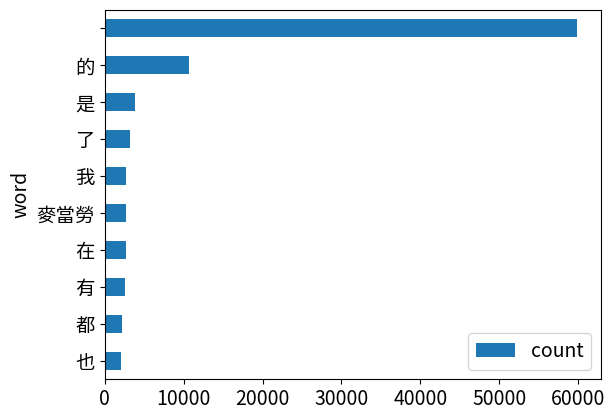

In [21]:
freq_df.head(10).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()

#### 繪製文字雲

In [22]:
# wordcloud的輸入須為dict，因此先將freq_df轉換成成dict
freq_dict = freq_df.set_index('word').to_dict()
freq_dict = freq_dict['count']

print(dict(list(freq_dict.items())[:10]))

{' ': 59887, '的': 10661, '是': 3770, '了': 3200, '我': 2679, '麥當勞': 2674, '在': 2634, '有': 2620, '都': 2137, '也': 2113}


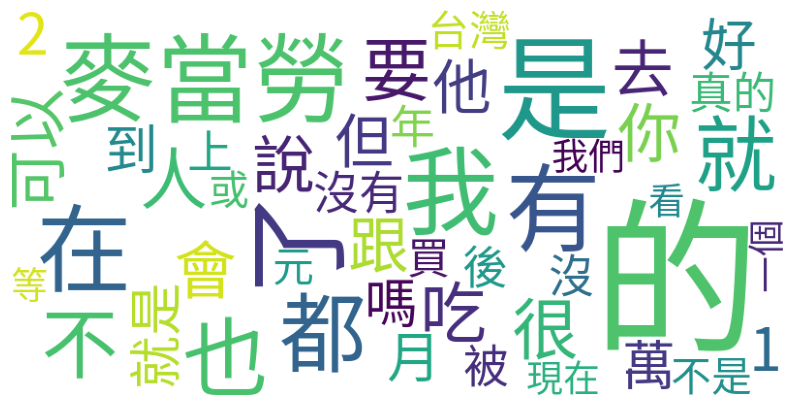

In [23]:
# 繪製文字雲
wordcloud = WordCloud(background_color = 'white', width = 800, height = 400, font_path = font_path, max_words = 50) #max_words: 詞頻前50高
wordcloud.generate_from_frequencies(freq_dict)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [24]:
#去除少於兩個字的詞語
word_df = word_df.loc[word_df['word'].str.len() > 1]

計算詞頻並繪製長條圖

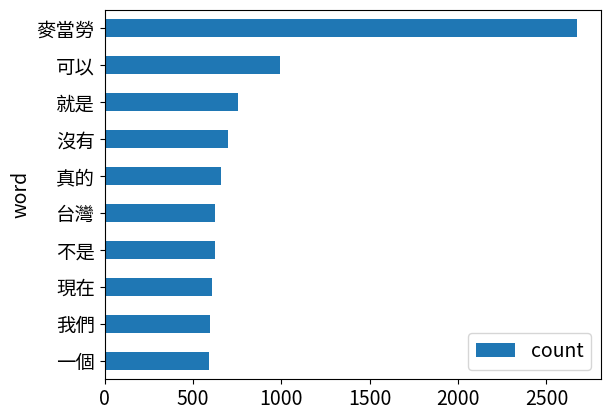

In [25]:
freq_df = pd.DataFrame(word_df['word'].value_counts()).sort_values(by = ['count'], ascending = False).reset_index()

freq_df.head(10).plot.barh(x = 'word', y = 'count').invert_yaxis()

plt.show()

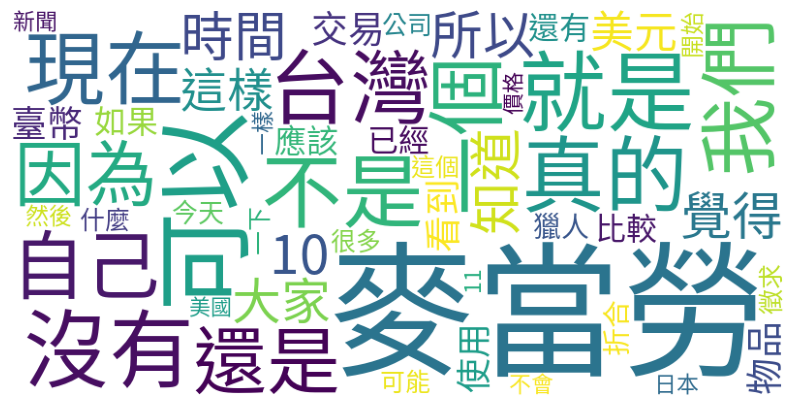

In [26]:
# wordcloud的輸入須為dict，因此先將freq_df轉換成成dict
freq_dict = freq_df.set_index('word').to_dict()
freq_dict = freq_dict['count']

# 繪製文字雲
wordcloud_no1 = WordCloud(background_color = 'white', width = 800, height = 400, font_path = font_path, max_words = 50)
wordcloud_no1.generate_from_frequencies(freq_dict)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud_no1)
plt.axis('off')
plt.show()

### 1.4 移除停用字

In [27]:
# 以檔案形式匯入通用的停用字檔案
# 將stopwords存成list
stopwords = [line.strip() for line in open('dict/stopwords.txt', 'r', encoding='utf-8').readlines()]

移除dataframe中的停用字

In [28]:
noStop_df = word_df[~word_df['word'].isin(stopwords)]

noStop_df.head(10)

artUrl      artTitle  \
1  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
1  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
1  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
1  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
1  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
1  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
1  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
2  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
2  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
3  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   

      artDate                                         artContent word  
1  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   小弟  
1  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   較少  
1  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   發文  
1  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   斷句  
1  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   怪怪  
1  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   地方  
1  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   見諒  
2  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   以下  
2  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   正文  
3  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   平常

計算去除停用字後的詞頻

/tmp/ipykernel_595663/583685406.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  freq_df_nostop = pd.DataFrame(pd.value_counts(noStop_df['word'])).sort_values(by = ['count'], ascending = False).reset_index()


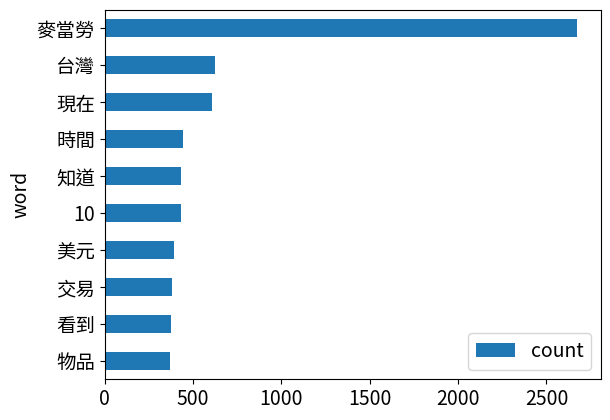

In [29]:
freq_df_nostop = pd.DataFrame(pd.value_counts(noStop_df['word'])).sort_values(by = ['count'], ascending = False).reset_index()

freq_df_nostop.head(10).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()

再次繪製文字雲

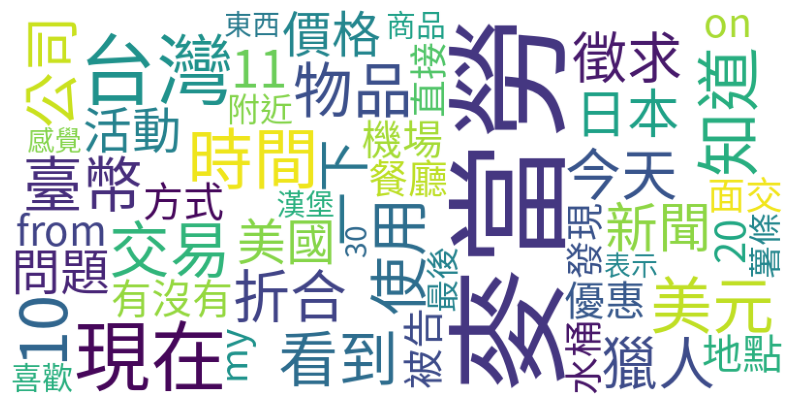

In [30]:
freq_dict_nostop = freq_df_nostop.set_index('word').to_dict()
freq_dict_nostop = freq_dict_nostop['count']

# 繪製文字雲
wordcloud_nostop = WordCloud(background_color = 'white', width = 800, height = 400, font_path = font_path, max_words = 50)
wordcloud_nostop.generate_from_frequencies(freq_dict_nostop)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.show()

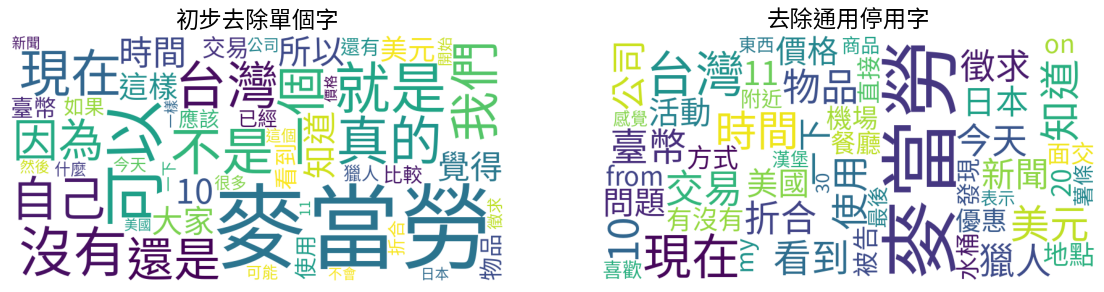

In [31]:
plt.figure(figsize = (14,8))

plt.subplot(1,2,1)
plt.imshow(wordcloud_no1)
plt.axis('off')
plt.title("初步去除單個字")

plt.subplot(1,2,2)
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.title("去除通用停用字")

plt.show()

### 1.5 更新停用字及斷詞字典

#### 更新停用字

In [32]:
# 參數形式手動加入停用字
stopwords_manual = ["麥當勞", "餐廳", "名稱", "消費", "時間", "地址", "營業", "吃起來", "一點", "使用", "每人", "平均", "價位", "吃到", "看到",'問題','嚴重','禁止',
                    '八卦','缺點','現在','水桶',"感覺","直接","方式","知道","東西","台灣","物品","這種","美元","臺幣","10","100","11","from","my","sent","最後",
                    "一下","分鐘","on","表示","20","今天","目前","公司","價格","折合","購買","交易","30","2024","一次","需要","30","15","Sent","好像","一堆",
                    "一直","iPhone","美國","地點","以前","根本","發現","附近","提供","說明","有沒有","川普","機場","中國","12","最近","根本","連結","JPTT","完全",
                    "日本","50","服務","內信","之後","希望","不用","特別","網路","晚上","交通","相關","建物","標題","內容","完整","一年","狀況","剛剛","高雄","生活",
                    "選擇","不錯","兩個",'媒體',"記者","朋友","台北","房屋","發文","全家","小時","地方","政府","來源","資訊","市場","兩個","飯店","台北","分享","台南",
                    "工作","盒裝","社會","方便","推薦","討論",'未來',"墾丁","台南市","指定","照片","保固","願意","繼續","員工","每天","店員","中心","報導","新聞",
                    "支持","XD","超過","謝謝","地區","打工","本文","注意","正常","出現","本來","全新","車位","包含","現場","裡面","阿肥","金額","車站","門市","前往",
                    "發表","商品","旁邊","國際","包含","期間","處理","變成","機會","民眾","至少","無法","聯絡","平台","小孩","美食","事件","兄弟","規定","行程","店家",
                    "萬人","14","網友","24","想要","認為","包含","看看","房東","日期","行李","事情","包括","一天","25","40","文章","電話","準備","世界","包含","上班",
                    "違者","需求","餐點","收到","企業","成本","手機","食物","東京","坪數","推出","同意","航空","711","Pro","增加","整個","青鳥","不可","好了","會不會",
                    "如題","環境","以下","安全","教育","立委","超商","網站","政治","去年","醫師","建議","飛機","內文","大樓","補貼","品牌","預算","突然","大樓","決定",
                    "情況","人力","BePTT","法律","111","算是","PTT","200","接受","拿到","導致","限於","一間","國內","權狀","中信","轉載","金年","下午","機能","網址",
                    "合作","影響","用餐","遇到","出發","售出","垃圾","市區","太多","配件","補充","註明","那種","早上","台中","發生","記得","活動","支付","今年","投資",
                    "過去","簡單","免費","數量","億元","刪除","成為","仲介","股票","指出","有限","本板","捷運","出門","主要","退文","便當","人員","沒什麼","買賣","售價",
                    "左右","銀行","感謝","館長","指出","詳閱","21","電梯","柯文哲","代表","規範","韓國","完成","公園","開車","每個","昨天","媽媽","以後","分店","主管",
                    "工資","口味","航班","實際","造成","16","類別","關係","影片","提出","拍照","房價","請問","集團","醫院","13","抵達","空間","食品","壽司","位於",
                    "上面","隨便","姓名","要求","適用","500","建中","出售","確實","明顯","類型","大學","23","回到","尤其","心得","事項","300","27","格局","型號",
                    "60","Line","民進黨","房子","不動產","國家","房租","LINE","保護","獲得","來到","運動","文化","app","幾個","越來越","吃完","前面","進來","原文",
                    "物價","進入","終於","終於","社區","還好","APP","減少","購入","點餐","建商","休息","重要","經典","還在","結帳","Samsung","銷售","好奇",
                    "想到","沒想到","結束","屋齡","舒服","一段","房間","位置","經濟","35"]
stopwords.extend(stopwords_manual)

In [33]:
noStop_df_2 = noStop_df[~noStop_df['word'].isin(stopwords)]
noStop_df_2.head(10)

artUrl      artTitle  \
1  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
1  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
1  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
1  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
1  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
2  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
3  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
3  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
3  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
3  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   

      artDate                                         artContent word  
1  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   小弟  
1  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   較少  
1  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   斷句  
1  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   怪怪  
1  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   見諒  
2  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   正文  
3  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   平常  
3  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   小弟  
3  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   亂摸  
3  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   習慣

/tmp/ipykernel_595663/2791560549.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  freq_df_nostop_2 = pd.DataFrame(pd.value_counts(noStop_df_2['word'])).sort_values(by = ['count'], ascending = False).reset_index()


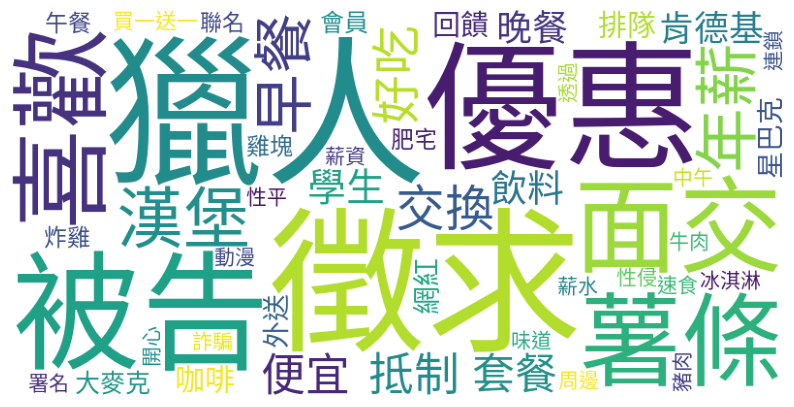

In [35]:
# 計算詞頻
freq_df_nostop_2 = pd.DataFrame(pd.value_counts(noStop_df_2['word'])).sort_values(by = ['count'], ascending = False).reset_index()

# wordcloud的輸入須為dict，因此先將freq_df轉換成成dict
freq_dict_nostop_2 = freq_df_nostop_2.set_index('word').to_dict()
freq_dict_nostop_2 = freq_dict_nostop_2['count']

# 繪製文字雲
wordcloud_nostop_2 = WordCloud(background_color = 'white', width = 800, height = 400, font_path = font_path, max_words = 50)
wordcloud_nostop_2.generate_from_frequencies(freq_dict_nostop_2)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud_nostop_2)
plt.axis('off')
plt.show()


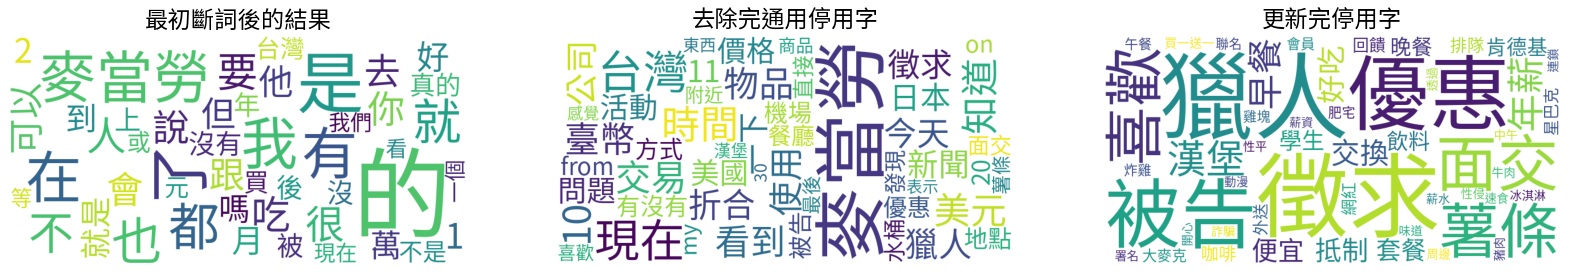

In [36]:
plt.figure(figsize = (20,14))

plt.subplot(1,3,1)
plt.imshow(wordcloud)
plt.axis('off')
plt.title("最初斷詞後的結果")

plt.subplot(1,3,2)
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.title("去除完通用停用字")

plt.subplot(1,3,3)
plt.imshow(wordcloud_nostop_2)
plt.axis('off')
plt.title("更新完停用字")

plt.show()

#### 更新斷詞字典
更新斷詞字典有兩種方法

a. 自行定義的斷詞字典

In [37]:
# 載入自定義辭典：一個詞一行，每行分詞語、詞頻(可省)、詞性(可省)
jieba.load_userdict("./dict/user_dict.txt")

b. 參數形式手動加入字詞

In [38]:
jieba.add_word('獵人公關品')
jieba.add_word('優惠活動')
jieba.add_word('襄理')
jieba.add_word('超值全餐')
jieba.add_word('玉米濃湯')

In [39]:
# 查看目前‘玉米濃湯’出現幾次
noStop_df_2[noStop_df_2['word'] == ('玉米濃湯')]['word'].count()

0

#### 重新斷詞

In [40]:
# sent_df是還沒斷詞過的df
word_df_updated = sent_df.assign(word = sent_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)

#把長度小於1的row刪掉
word_df_updated = word_df_updated.loc[word_df_updated['word'].str.len()>1]
word_df_updated

artUrl          artTitle  \
0      https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...      腮腺癌1期開刀分享與詢問   
0      https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...      腮腺癌1期開刀分享與詢問   
1      https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...      腮腺癌1期開刀分享與詢問   
1      https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...      腮腺癌1期開刀分享與詢問   
1      https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...      腮腺癌1期開刀分享與詢問   
...                                                  ...               ...   
53286  https://www.ptt.cc/bbs/WomenTalk/M.1741178079....  [閒聊]吃高熱量垃圾食物or酗酒   
53286  https://www.ptt.cc/bbs/WomenTalk/M.1741178079....  [閒聊]吃高熱量垃圾食物or酗酒   
53286  https://www.ptt.cc/bbs/WomenTalk/M.1741178079....  [閒聊]吃高熱量垃圾食物or酗酒   
53288  https://www.ptt.cc/bbs/WomenTalk/M.1741178079....  [閒聊]吃高熱量垃圾食物or酗酒   
53288  https://www.ptt.cc/bbs/WomenTalk/M.1741178079....  [閒聊]吃高熱量垃圾食物or酗酒   

          artDate                                         artContent word  
0      2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   各位  
0      2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   大大  
1      2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   小弟  
1      2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   較少  
1      2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   發文  
...           ...                                                ...  ...  
53286  2025-03-05  大家好\n因為壓力有點大兒啦\n\n晚餐已經吃一桶拿坡里烤雞\n吃完還是很餓\n覺得超級不滿...   變成  
53286  2025-03-05  大家好\n因為壓力有點大兒啦\n\n晚餐已經吃一桶拿坡里烤雞\n吃完還是很餓\n覺得超級不滿...  他媽的  
53286  2025-03-05  大家好\n因為壓力有點大兒啦\n\n晚餐已經吃一桶拿坡里烤雞\n吃完還是很餓\n覺得超級不滿...   肥豬  
53288  2025-03-05  大家好\n因為壓力有點大兒啦\n\n晚餐已經吃一桶拿坡里烤雞\n吃完還是很餓\n覺得超級不滿...   給點  
53288  2025-03-05  大家好\n因為壓力有點大兒啦\n\n晚餐已經吃一桶拿坡里烤雞\n吃完還是很餓\n覺得超級不滿...   意見  

[204955 rows x 5 columns]

#### 重新移除停用字

In [41]:
nostop_df_updated = word_df_updated[~word_df_updated['word'].isin(stopwords)]

nostop_df_updated

artUrl          artTitle  \
1      https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...      腮腺癌1期開刀分享與詢問   
1      https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...      腮腺癌1期開刀分享與詢問   
1      https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...      腮腺癌1期開刀分享與詢問   
1      https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...      腮腺癌1期開刀分享與詢問   
1      https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...      腮腺癌1期開刀分享與詢問   
...                                                  ...               ...   
53284  https://www.ptt.cc/bbs/WomenTalk/M.1741178079....  [閒聊]吃高熱量垃圾食物or酗酒   
53286  https://www.ptt.cc/bbs/WomenTalk/M.1741178079....  [閒聊]吃高熱量垃圾食物or酗酒   
53286  https://www.ptt.cc/bbs/WomenTalk/M.1741178079....  [閒聊]吃高熱量垃圾食物or酗酒   
53288  https://www.ptt.cc/bbs/WomenTalk/M.1741178079....  [閒聊]吃高熱量垃圾食物or酗酒   
53288  https://www.ptt.cc/bbs/WomenTalk/M.1741178079....  [閒聊]吃高熱量垃圾食物or酗酒   

          artDate                                         artContent  word  
1      2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...    小弟  
1      2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...    較少  
1      2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...    斷句  
1      2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...    怪怪  
1      2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...    見諒  
...           ...                                                ...   ...  
53284  2025-03-05  大家好\n因為壓力有點大兒啦\n\n晚餐已經吃一桶拿坡里烤雞\n吃完還是很餓\n覺得超級不滿...  不省人事  
53286  2025-03-05  大家好\n因為壓力有點大兒啦\n\n晚餐已經吃一桶拿坡里烤雞\n吃完還是很餓\n覺得超級不滿...   他媽的  
53286  2025-03-05  大家好\n因為壓力有點大兒啦\n\n晚餐已經吃一桶拿坡里烤雞\n吃完還是很餓\n覺得超級不滿...    肥豬  
53288  2025-03-05  大家好\n因為壓力有點大兒啦\n\n晚餐已經吃一桶拿坡里烤雞\n吃完還是很餓\n覺得超級不滿...    給點  
53288  2025-03-05  大家好\n因為壓力有點大兒啦\n\n晚餐已經吃一桶拿坡里烤雞\n吃完還是很餓\n覺得超級不滿...    意見  

[128810 rows x 5 columns]

In [42]:
# 查看目前‘玉米濃湯’出現幾次
nostop_df_updated[nostop_df_updated['word'] == ('玉米濃湯')]['word'].count()

12

In [43]:
jieba.del_word('玉米濃湯') # 先將‘玉米濃湯’字詞從斷詞字典中移除
jieba.add_word('玉米濃湯', freq = 500)  # 加上詞頻後重新加入斷詞字典

重新進行斷詞及清除停用字

In [44]:
# sent_df是還沒斷詞過的df
word_df_updated = sent_df.assign(word = sent_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)

#把長度小於1的row刪掉
word_df_updated = word_df_updated.loc[word_df_updated['word'].str.len()>1]

#去除停用字
nostop_df_updated = word_df_updated[~word_df_updated['word'].isin(stopwords)]

nostop_df_updated.head(10)

artUrl      artTitle  \
1  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
1  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
1  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
1  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
1  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
2  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
3  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
3  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
3  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
3  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   

      artDate                                         artContent word  
1  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   小弟  
1  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   較少  
1  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   斷句  
1  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   怪怪  
1  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   見諒  
2  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   正文  
3  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   平常  
3  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   小弟  
3  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   亂摸  
3  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   習慣

In [45]:
# 查看調整詞頻之後‘玉米濃湯’出現幾次
nostop_df_updated[nostop_df_updated['word'] == ('玉米濃湯')]['word'].count()

12

經過比對可以看到該詞的數量上升，代表該詞更加精準地被拆分了出來。

#### 重新計算詞頻

In [46]:
freq_df_updated = pd.DataFrame(pd.value_counts(nostop_df_updated['word'])).sort_values(by = ['count'], ascending = False).reset_index()

freq_df_updated.head(10)

/tmp/ipykernel_595663/1450957720.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  freq_df_updated = pd.DataFrame(pd.value_counts(nostop_df_updated['word'])).sort_values(by = ['count'], ascending = False).reset_index()


word  count
0   獵人    328
1   徵求    314
2   被告    239
3   優惠    239
4   面交    237
5   薯條    226
6   喜歡    220
7   漢堡    205
8   年薪    193
9   早餐    172

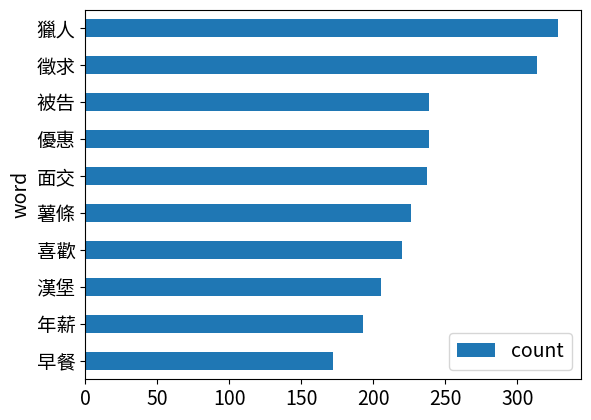

In [47]:
freq_df_updated.head(10).plot.barh(x='word', y='count').invert_yaxis()
plt.show()

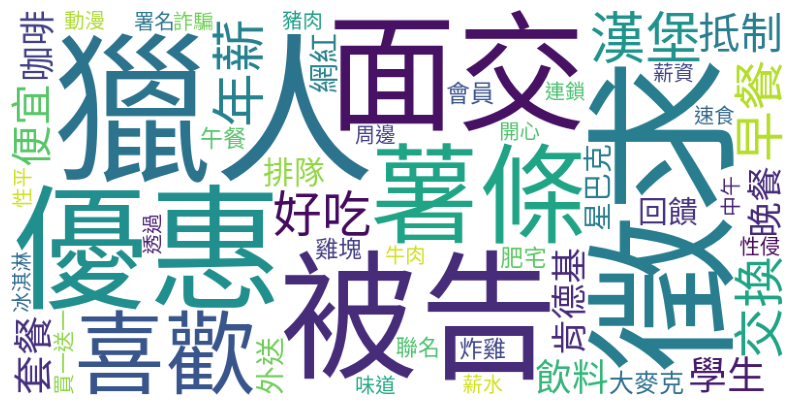

In [48]:
freq_dict_updated = freq_df_updated.set_index('word').to_dict()
freq_dict_updated = freq_dict_updated['count']

# 繪製文字雲
wordcloud_after = WordCloud(background_color='white', width=800, height = 400, font_path = font_path, max_words = 50)
wordcloud_after.generate_from_frequencies(freq_dict_updated)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud_after)
plt.axis('off')
plt.show()

### 1.6 比較清理前後的文字雲

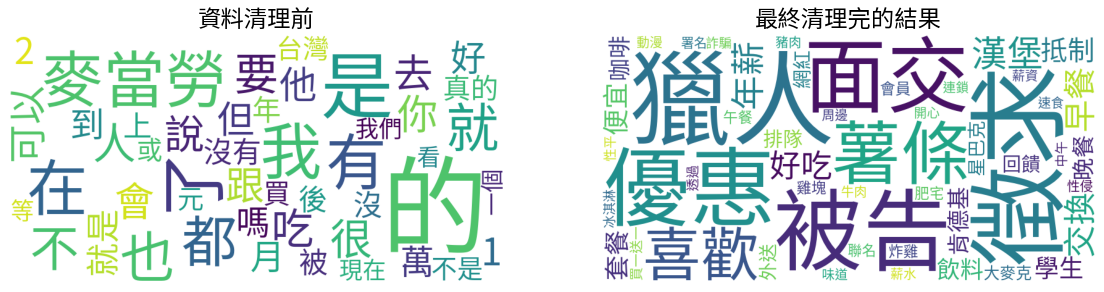

In [49]:
plt.figure(figsize = (14,8))

plt.subplot(1,2,1)
plt.imshow(wordcloud)
plt.axis('off')
plt.title("資料清理前")

plt.subplot(1,2,2)
plt.imshow(wordcloud_after)
plt.axis('off')
plt.title("最終清理完的結果")

plt.show()

儲存clean data，以便後續其他使用

In [50]:
nostop_df_updated.to_csv("raw_data/clean_MC.csv", encoding = 'utf-8',index = False)

## 2. 情緒分析 (一)
進行基於情緒字典的情緒分析，首先需要準備情緒字典後再將字典與斷詞後的文章進行合併

### 2.1 準備LIWC情緒字典

In [78]:
# 讀取情緒字典
liwc_dict = pd.read_csv("./dict/liwc/LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
liwc_dict.head()

word sentiments
0   ):     affect
1   3q     affect
2   :(     affect
3   :)     affect
4   <3     affect

### 2.2 情緒字典與斷詞結果進行合併
將情緒字典與斷詞結果進行合併。

In [79]:
#共同head: word，去根據情緒字典內容與word和sentiments做對接
ptt_liwc_df = pd.merge(nostop_df_updated[["artUrl", "artDate", "artTitle", "artContent", "word"]], liwc_dict, how="left")
ptt_liwc_df.head()

artUrl     artDate  \
0  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  2025-01-07   
1  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  2025-01-07   
2  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  2025-01-07   
3  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  2025-01-07   
4  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  2025-01-07   

       artTitle                                         artContent word  \
0  腮腺癌1期開刀分享與詢問  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   小弟   
1  腮腺癌1期開刀分享與詢問  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   較少   
2  腮腺癌1期開刀分享與詢問  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   斷句   
3  腮腺癌1期開刀分享與詢問  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   怪怪   
4  腮腺癌1期開刀分享與詢問  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   見諒   

  sentiments  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN

### 2.3 正負向情緒詞彙頻率折線圖圖
分別畫出文集中，正向（positive）與負向（negative）情緒的折線圖

In [80]:
sentiment_count = pd.DataFrame(
    ptt_liwc_df.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count['sentiments'] == "positive") | (sentiment_count['sentiments'] == "negative")
sentiment_count = sentiment_count.loc[mask]

sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["artDate"])
#sentiment_count.head(10)

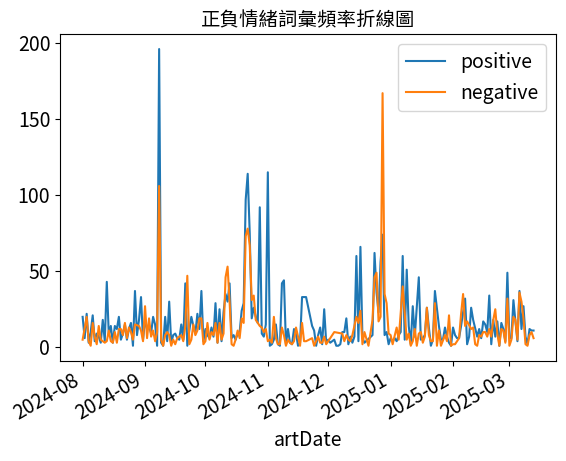

In [81]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

ax.plot(pos["artDate"], pos["size"], color=colors[0])
ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒詞彙頻率折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

```Moving average```
- rolling average（滾動平均）是一種將時間序列數據平滑化的技術，有助於去除數據中的噪聲，使趨勢更加明顯，同時仍然保留一定的時間特徵。
- 在情緒分析中，特別是當你有一系列時間序列的情緒數據時，使用滾動平均有助於平滑數據，使情緒趨勢更加清晰。
    1. **去除瞬間噪聲**： 情緒數據可能受到瞬間事件或噪聲的影響，例如突發的大量評論或新聞。滾動平均有助於平滑這些突變，使你更容易觀察到整體趨勢。
    2. **強調長期趨勢**： 滾動平均有助於強調長期情緒趨勢，而不受短期波動的干擾。這對於觀察情緒的漸變和長期變化非常有用。


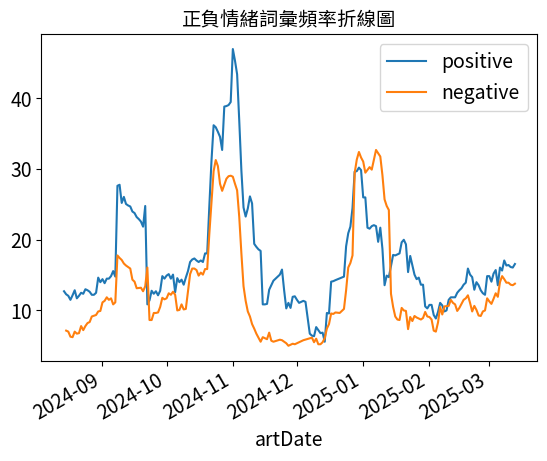

In [82]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒詞彙頻率折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

```詞頻缺點```

如果某一天有什麼事件發生而導致正負向詞頻數隨之飆高，在趨勢圖看來可能會認為該區間的正負向情緒較為顯著，但也有可能是因為總體情緒詞彙本來就比較多而導致的。

以比例的方式來看，我們可以觀察到某個情緒詞在總體情緒詞彙中所佔的比例，就算某一天文章數相較多，也不會影響到比例的呈現。

### 2.4 正負向情緒詞彙比例折線圖圖

In [83]:
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("artDate")["size"].transform(lambda n: n / n.sum())
)
sentiment_count.head(10)

artDate sentiments  size     ratio
2   2024-08-01   negative     5  0.200000
3   2024-08-01   positive    20  0.800000
6   2024-08-02   positive     6  1.000000
10  2024-08-03   negative    20  0.476190
11  2024-08-03   positive    22  0.523810
16  2024-08-04   negative     4  0.571429
17  2024-08-04   positive     3  0.428571
19  2024-08-05   negative     1  0.090909
20  2024-08-05   positive    10  0.909091
24  2024-08-06   negative    16  0.432432

In [84]:
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

Text(0.5, 1.0, '正負情緒比例折線圖')

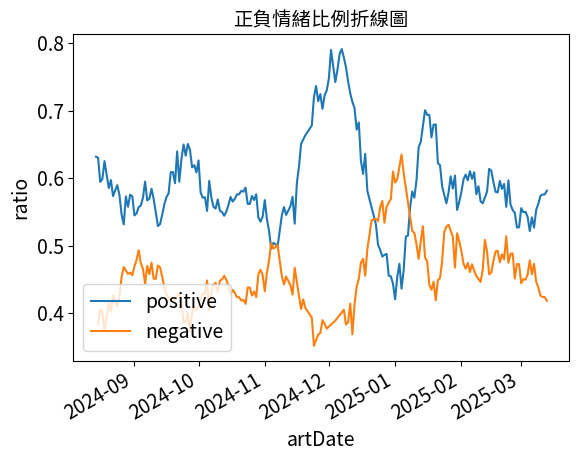

In [85]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(pos["artDate"], pos["ratio"].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["ratio"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
plt.ylabel("ratio")
ax.legend(["positive", "negative"], loc="lower left")
fig.autofmt_xdate()
plt.title("正負情緒比例折線圖", fontproperties=fprop)

### 2.5 正負向情緒分數折線圖

In [86]:
#用pivot把df的sentiments拆成col
ptt_sentiment_value = (
    sentiment_count.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value.head()

artDate  negative  positive
0  2024-08-01       5.0      20.0
1  2024-08-02       0.0       6.0
2  2024-08-03      20.0      22.0
3  2024-08-04       4.0       3.0
4  2024-08-05       1.0      10.0

In [87]:
# sentiment 計算方式: positive - negative
ptt_sentiment_value["sentiment_value"] = (
    ptt_sentiment_value["positive"]
    - ptt_sentiment_value["negative"]
)
ptt_sentiment_value.head()

artDate  negative  positive  sentiment_value
0  2024-08-01       5.0      20.0             15.0
1  2024-08-02       0.0       6.0              6.0
2  2024-08-03      20.0      22.0              2.0
3  2024-08-04       4.0       3.0             -1.0
4  2024-08-05       1.0      10.0              9.0

Text(0.5, 1.0, '正負情緒分數趨勢折線圖')

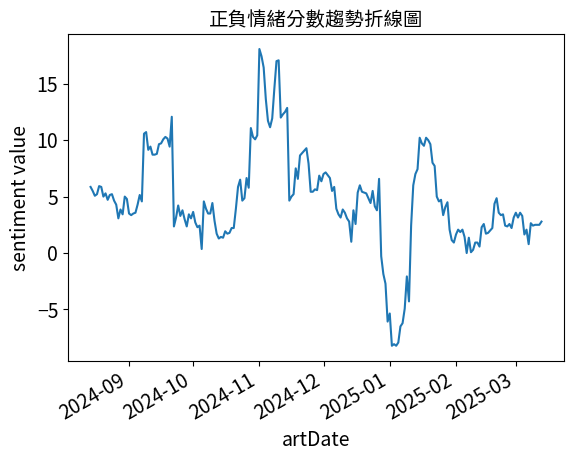

In [88]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value["artDate"], ptt_sentiment_value["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("正負情緒分數趨勢折線圖", fontproperties=fprop)

### 2.6 文章為單位的情緒分析

In [89]:
sentiment_count_by_article = pd.DataFrame(
    ptt_liwc_df.groupby(["artUrl", "sentiments"]).size()
).reset_index()
sentiment_count_by_article = sentiment_count_by_article.rename(columns={0: "size"})
sentiment_count_by_article.head(10)

artUrl sentiments  size
0  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...     affect    23
1  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...        anx     3
2  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...   negative    10
3  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...   positive    12
4  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...        sad     2
5  https://www.ptt.cc/bbs/Aviation/M.1730036309.A...     affect     4
6  https://www.ptt.cc/bbs/Aviation/M.1730036309.A...   positive     1
7  https://www.ptt.cc/bbs/Aviation/M.1731938934.A...     affect    18
8  https://www.ptt.cc/bbs/Aviation/M.1731938934.A...   negative     1
9  https://www.ptt.cc/bbs/Aviation/M.1731938934.A...   positive    14

In [90]:
#用pivot把df的sentiments拆成col
ptt_sentiment_value_by_article = (
    sentiment_count_by_article.pivot_table(
        index="artUrl", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value_by_article.head()

artUrl  affect  anger  anx  \
0  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...    23.0    0.0  3.0   
1  https://www.ptt.cc/bbs/Aviation/M.1730036309.A...     4.0    0.0  0.0   
2  https://www.ptt.cc/bbs/Aviation/M.1731938934.A...    18.0    0.0  0.0   
3  https://www.ptt.cc/bbs/Aviation/M.1735051805.A...    27.0    1.0  2.0   
4  https://www.ptt.cc/bbs/Aviation/M.1735310682.A...     9.0    0.0  0.0   

   negative  positive  sad  
0      10.0      12.0  2.0  
1       0.0       1.0  0.0  
2       1.0      14.0  0.0  
3       6.0      20.0  0.0  
4       2.0       7.0  1.0

In [91]:
# sentiment 計算方式: positive - negative
#下面就單純正面-負面，沒算其他情緒
ptt_sentiment_value_by_article["sentiment_value"] = (
    ptt_sentiment_value_by_article["positive"]
    - ptt_sentiment_value_by_article["negative"]
)
ptt_sentiment_value_by_article.head()

artUrl  affect  anger  anx  \
0  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...    23.0    0.0  3.0   
1  https://www.ptt.cc/bbs/Aviation/M.1730036309.A...     4.0    0.0  0.0   
2  https://www.ptt.cc/bbs/Aviation/M.1731938934.A...    18.0    0.0  0.0   
3  https://www.ptt.cc/bbs/Aviation/M.1735051805.A...    27.0    1.0  2.0   
4  https://www.ptt.cc/bbs/Aviation/M.1735310682.A...     9.0    0.0  0.0   

   negative  positive  sad  sentiment_value  
0      10.0      12.0  2.0              2.0  
1       0.0       1.0  0.0              1.0  
2       1.0      14.0  0.0             13.0  
3       6.0      20.0  0.0             14.0  
4       2.0       7.0  1.0              5.0

In [92]:
#根據分數+上class欄位
ptt_sentiment_value_by_article['sentiment_class'] = ptt_sentiment_value_by_article['sentiment_value'].apply(lambda x: "正向" if x > 0 else "負向" )
ptt_sentiment_value_by_article.head(10)

artUrl  affect  anger  anx  \
0  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...    23.0    0.0  3.0   
1  https://www.ptt.cc/bbs/Aviation/M.1730036309.A...     4.0    0.0  0.0   
2  https://www.ptt.cc/bbs/Aviation/M.1731938934.A...    18.0    0.0  0.0   
3  https://www.ptt.cc/bbs/Aviation/M.1735051805.A...    27.0    1.0  2.0   
4  https://www.ptt.cc/bbs/Aviation/M.1735310682.A...     9.0    0.0  0.0   
5  https://www.ptt.cc/bbs/Aviation/M.1738053797.A...    19.0    1.0  2.0   
6  https://www.ptt.cc/bbs/Aviation/M.1738673834.A...     8.0    0.0  0.0   
7  https://www.ptt.cc/bbs/Aviation/M.1739149738.A...    17.0    1.0  1.0   
8  https://www.ptt.cc/bbs/Aviation/M.1739261340.A...    25.0    1.0  1.0   
9  https://www.ptt.cc/bbs/BabyMother/M.1722573780...     5.0    0.0  0.0   

   negative  positive  sad  sentiment_value sentiment_class  
0      10.0      12.0  2.0              2.0              正向  
1       0.0       1.0  0.0              1.0              正向  
2       1.0      14.0  0.0             13.0              正向  
3       6.0      20.0  0.0             14.0              正向  
4       2.0       7.0  1.0              5.0              正向  
5       6.0      11.0  2.0              5.0              正向  
6       4.0       4.0  1.0              0.0              負向  
7       5.0      12.0  1.0              7.0              正向  
8       8.0      14.0  2.0              6.0              正向  
9       0.0       5.0  0.0              5.0              正向

In [93]:
clear_df_sentiment = pd.merge(df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
clear_df_sentiment["artDate"] = pd.to_datetime(clear_df_sentiment["artDate"])
clear_df_sentiment['artDate'] = clear_df_sentiment['artDate'].dt.date

clear_df_sentiment.head()

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...   
1          2  https://www.ptt.cc/bbs/Aves/M.1726281094.A.92B...   
2          3  https://www.ptt.cc/bbs/Aviation/M.1727865058.A...   
3          4  https://www.ptt.cc/bbs/Aviation/M.1730036309.A...   
4          5  https://www.ptt.cc/bbs/Aviation/M.1731938934.A...   

                     artTitle     artDate  artPoster  artCatagory  \
0                腮腺癌1期開刀分享與詢問  2025-01-07  allen9834  Anti_Cancer   
1               [協尋]板橋江子翠綠色鸚鵡  2024-09-14       quiy         Aves   
2  [分享]西班牙MallorcaPMI帕爾馬機場貴賓室  2024-10-02    vikimsw     Aviation   
3        [閒聊]成田機場二航管制區外商店、展望台  2024-10-27   osakaleo     Aviation   
4      [分享]AirAsia高雄-亞庇全新航班首航  2024-11-18    vhygdih     Aviation   

                                          artContent  \
0  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   
1  在文化路二段麥當勞對面紅綠燈上面\nhttp://i.imgur.com/k5vm7ZI.j...   
2  初次來到Mallorca島，在Palma de Mallorca Airport帕爾馬機場，...   
3  有圖有真相網誌版：\nhttps://osakaleo.pixnet.net/blog/po...   
4  完整圖文介紹:\nhttps://www.thomaskhh.com/airasiabkik...   

                                          artComment             e_ip  \
0  [{"cmtStatus": "推", "cmtPoster": "Euglena", "c...   111.184.14.201   
1  [{"cmtStatus": "→", "cmtPoster": "quiy", "cmtC...  114.136.162.106   
2  [{"cmtStatus": "→", "cmtPoster": "forcal", "cm...     112.78.66.46   
3  [{"cmtStatus": "推", "cmtPoster": "jxigjll", "c...     42.79.188.29   
4  [{"cmtStatus": "推", "cmtPoster": "Kazamatsuri"...   118.101.47.114   

          insertedDate dataSource sentiment_class  
0  2025-01-08 01:00:16        ptt              正向  
1  2024-09-15 01:00:35        ptt             NaN  
2  2024-10-03 01:00:42        ptt             NaN  
3  2024-10-28 01:00:42        ptt              正向  
4  2024-11-19 01:00:44        ptt              正向

In [94]:
sentiment_art_count = pd.DataFrame(
    clear_df_sentiment.groupby(["artDate", "sentiment_class"]).size()
).reset_index()
sentiment_art_count = sentiment_art_count.rename(columns={0: "size"})
sentiment_art_count = sentiment_art_count.sort_values(["artDate"])
sentiment_art_count

artDate sentiment_class  size
0    2024-08-01              正向     6
1    2024-08-01              負向     3
2    2024-08-02              正向     2
3    2024-08-03              正向     3
4    2024-08-03              負向     2
..          ...             ...   ...
380  2025-03-11              負向     6
381  2025-03-12              正向     4
382  2025-03-12              負向     4
383  2025-03-13              正向     2
384  2025-03-13              負向     3

[385 rows x 3 columns]

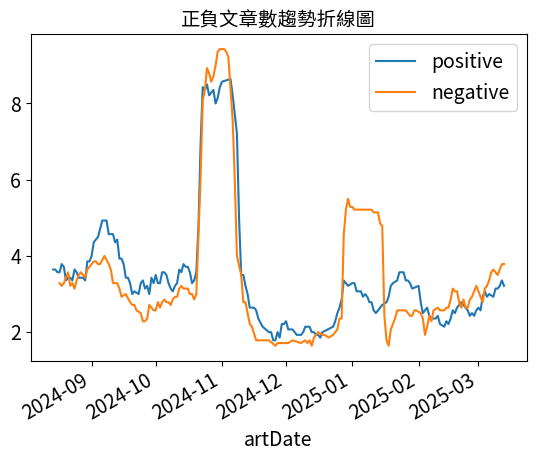

In [95]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_art_count[sentiment_art_count["sentiment_class"] == "正向"]
neg = sentiment_art_count[sentiment_art_count["sentiment_class"] == "負向"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])
# ax.plot(pos["artDate"], pos['size'], color=colors[0])
# ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負文章數趨勢折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

### 2.7 情緒代表字

In [96]:
word_count = ptt_liwc_df.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)

word_count.head(10)

word sentiments  size
202    優惠   positive   239
201    優惠     affect   239
416    喜歡     affect   220
417    喜歡   positive   220
544    好吃     affect   168
545    好吃   positive   168
967    抵制     affect   162
968    抵制   negative   162
1932   開心     affect    67
1933   開心   positive    67

In [97]:
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_pos.head(15)

word sentiments  size
202    優惠   positive   239
417    喜歡   positive   220
545    好吃   positive   168
1933   開心   positive    67
1896   遊戲   positive    53
170    健康   positive    53
1288   清楚   positive    50
1204   歡迎   positive    50
1909   適合   positive    49
658    幫忙   positive    48
611    容易   positive    46
1517   相信   positive    46
1991   順利   positive    45
897    成功   positive    44
1541   確定   positive    41

In [98]:
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
word_of_neg.head(15)

word sentiments  size
968    抵制   negative   162
1779   詐騙   negative    59
1046   擔心   negative    48
2043   麻煩   negative    39
1076   放棄   negative    32
479    壓力   negative    29
1774   討厭   negative    28
1789   誤解   negative    28
538    奇怪   negative    27
1503   瘋狂   negative    26
1219   死亡   negative    26
1905   違規   negative    26
1006   控制   negative    26
442    嚴格   negative    25
1928   錯誤   negative    25

/tmp/ipykernel_595663/741308677.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
/tmp/ipykernel_595663/741308677.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(neg["word"], fontproperties=fprop)


Text(0.5, 1.0, '負向情緒總數')

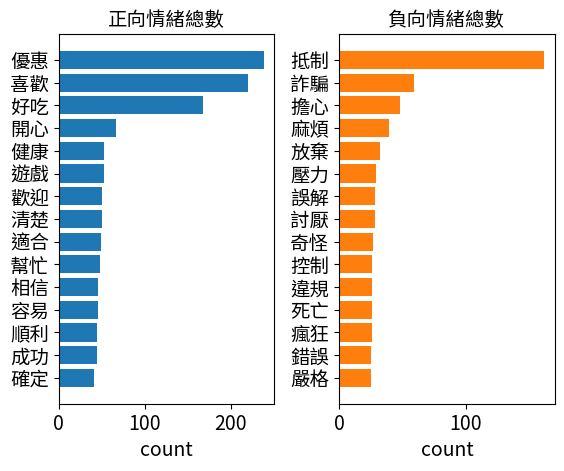

In [99]:
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)
fig.subplots_adjust(wspace=0.3)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
ax[0].set_title("正向情緒總數", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
ax[1].set_title("負向情緒總數", fontproperties=fprop)

In [142]:
filtered_df = sent_df[sent_df['sentence'].str.contains('拒絕', na=False)] #這裡可以依照自己對上面那些詞有興趣自己改
filtered_df.head()

artUrl  \
1514  https://www.ptt.cc/bbs/CVS/M.1729493445.A.42C....   
2280  https://www.ptt.cc/bbs/gay/M.1728746369.A.0F8....   
4878  https://www.ptt.cc/bbs/Gossiping/M.1725169848....   
5155  https://www.ptt.cc/bbs/Gossiping/M.1725338775....   
5517  https://www.ptt.cc/bbs/Gossiping/M.1725781129....   

                        artTitle     artDate  \
1514      [新聞]女子買熱咖啡燙手飆罵店員網友怒批：刁  2024-10-21   
2280          [小說]我的健身教練很恐同番外+後記  2024-10-12   
4878       [新聞]北檢外開直播遭搶器材！網紅四叉貓：  2024-09-01   
5155          [問卦]新竹有什麼值得說嘴的小吃啊☹  2024-09-03   
5517  Re:[新聞]護理師院內偷吃醫師！放話「讓你腳軟」　  2024-09-08   

                                             artContent  \
1514  https://udn.com/news/story/7186/8304229\n女子買熱咖...   
2280  來說後記\n\n「如果有一天，我們再見面，時間會不會倒退一點？\n也許我們都忽略，互相傷害之...   
4878  中時\n\n李啟箖 賴佩璇\n\n北檢外開直播遭搶器材！ 網紅四叉貓：民眾黨欺侮我一個弱女子...   
5155  如標題。\n\n本魯在新竹住惹幾年了，\n\n一直有個蠻困擾的問題，\n\n尤其是最近，\n...   
5517  參照「臺灣桃園地方法院一一二年度訴字第一八二六號民事判決」\n\n對話內容譯本佔了整份判決書...   

                                               sentence  
1514                                               卻遭拒絕  
2280                                            林志林沒有拒絕  
4878                                         但因主張拒絕夜間偵訊  
5155                                         基本上是拒絕往來戶了  
5517  所以應該找                                時間慶祝身體健康吧...

In [143]:
for sentence in filtered_df['sentence'].to_list():
    print(sentence)
    print("=========================")

卻遭拒絕
林志林沒有拒絕
但因主張拒絕夜間偵訊
基本上是拒絕往來戶了
所以應該找                                時間慶祝身體健康吧                        被告    你好久沒有好好休假了很心疼ㄟ                                早安                        丙  早安                                我跟我兒子一樣是過動體質可能無法坐在那很久等妳                                畫完我還是在咳啊                                還沒完全好                                還不用慶祝啦                        被告    我在買早餐                                期待生活有你的每一天會有很多開心的事                        丙  要去上班了                                剛補眠完                        被告    大家都說你人超好其實真的可以拒絕盡量門診追蹤                                就好
                        被告    但是我也不覺得有那麼幸運會不小心中獎週期啦                        丙  妳沒講白我還真不知道耶                        被告    萬一又來弟弟妹妹                        丙  那妳第一次幹嘛唬我                        被告    你們會更累吧                        丙  還記得在沙發上那次                                哼                        被告    沒唬你啦                        丙  有哇                                當我想煞車時                                妳

#### 重新計算情緒

去除停用詞

In [136]:
# 設定要移除的字詞列表
words_to_remove = ['瘋狂','嚴格','違規','討厭','誤解','壓力','擔心','健康']

# 使用 ~ 運算子和 isin() 方法過濾掉包含在 words_to_remove 列表中的行
liwc_dict_revise = liwc_dict[~liwc_dict['word'].isin(words_to_remove)]
# 使用更新後的情緒字典 merge
ptt_liwc_df_revise = pd.merge(nostop_df_updated[["artUrl", "artDate", "artTitle", "artContent","word"]], liwc_dict_revise, how="left")
#ptt_liwc_df_revise.head()

/tmp/ipykernel_595663/1971206132.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
/tmp/ipykernel_595663/1971206132.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(neg["word"], fontproperties=fprop)


Text(0.5, 1.0, '負向情緒總數')

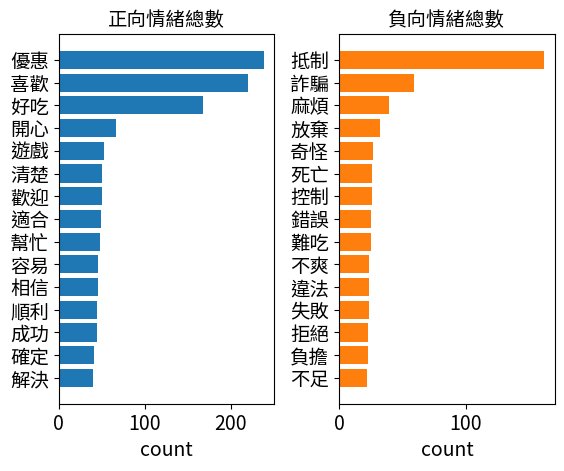

In [137]:
word_count = ptt_liwc_df_revise.groupby(["word", "sentiments"]).size().reset_index()

word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)

word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]

pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)
fig.subplots_adjust(wspace=0.3)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
ax[0].set_title("正向情緒總數", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
ax[1].set_title("負向情緒總數", fontproperties=fprop)

重新繪製情緒分數趨勢圖

Text(0.5, 1.0, '正負情緒分數趨勢折線圖')

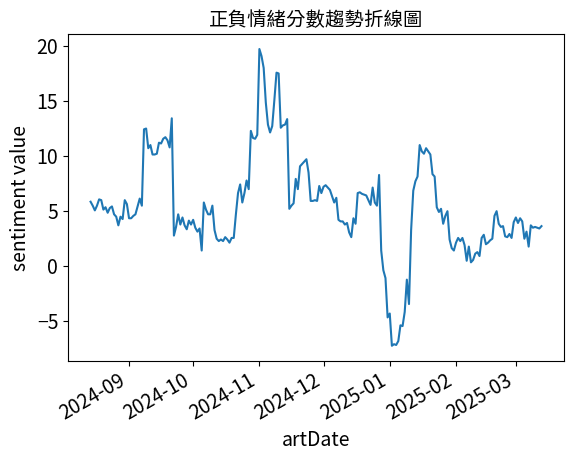

In [144]:
sentiment_count_revise = pd.DataFrame(
    ptt_liwc_df_revise.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count_revise['sentiments'] == "positive") | (sentiment_count_revise['sentiments'] == "negative")
sentiment_count_revise = sentiment_count_revise.loc[mask]

sentiment_count_revise = sentiment_count_revise.rename(columns={0: "size"})
sentiment_count_revise = sentiment_count_revise.sort_values(["artDate"])

ptt_sentiment_value_revise = (
    sentiment_count_revise.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)

# sentiment 計算方式: positive - negative
ptt_sentiment_value_revise["sentiment_value"] = (
    ptt_sentiment_value_revise["positive"]
    - ptt_sentiment_value_revise["negative"]
)

# 繪製情緒分數趨勢圖
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value_revise["artDate"], ptt_sentiment_value_revise["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("正負情緒分數趨勢折線圖", fontproperties=fprop)

### 2.8 文字雲

#### 2025-01-01 ~ 2025-03-13 文字雲
將前面計算出的文章情緒類別合併，以利我們過濾出負面文章資料

In [145]:
ptt_liwc_df_revise = pd.merge(ptt_liwc_df_revise, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
ptt_liwc_df_revise.head()

artUrl     artDate  \
0  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  2025-01-07   
1  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  2025-01-07   
2  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  2025-01-07   
3  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  2025-01-07   
4  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  2025-01-07   

       artTitle                                         artContent word  \
0  腮腺癌1期開刀分享與詢問  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   小弟   
1  腮腺癌1期開刀分享與詢問  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   較少   
2  腮腺癌1期開刀分享與詢問  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   斷句   
3  腮腺癌1期開刀分享與詢問  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   怪怪   
4  腮腺癌1期開刀分享與詢問  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   見諒   

  sentiments sentiment_class  
0        NaN              正向  
1        NaN              正向  
2        NaN              正向  
3        NaN              正向  
4        NaN              正向

In [146]:
#sent_df是只有斷句沒斷詞
sent_df = pd.merge(sent_df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
sent_df.head()

artUrl      artTitle  \
0  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
1  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
2  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
3  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   
4  https://www.ptt.cc/bbs/Anti-Cancer/M.173625806...  腮腺癌1期開刀分享與詢問   

      artDate                                         artContent  \
0  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   
1  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   
2  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   
3  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   
4  2025-01-07  各位大大好\n\n小弟較少發文如果斷句有怪怪的地方再請見諒，\n以下正文：\n平常小弟就會有...   

                    sentence sentiment_class  
0                      各位大大好              正向  
1       小弟較少發文如果斷句有怪怪的地方再請見諒              正向  
2          以下正文平常小弟就會有亂摸臉的習慣              正向  
3  所以在202305左右摸到耳朵下方有一顆凸凸的腫塊              正向  
4                      很硬不會痛              正向

In [147]:
date = "2025-01-01"
end_date = "2025-03-13"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & (
    ptt_liwc_df_revise['sentiment_class'] == "負向")

ptt_df_wc = ptt_liwc_df_revise.loc[mask]
#ptt_df_wc.head(10)

In [148]:
date = "2025-01-01"
end_date = "2025-03-13"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & (
    ptt_liwc_df_revise['sentiment_class'] == "負向")

ptt_df_wc = ptt_liwc_df_revise.loc[mask, ["artDate", "word"]]


word_count_count = pd.DataFrame(
    ptt_df_wc.groupby(["word"]).size()
).reset_index().rename(columns={0: "size"})

word_count_count = word_count_count.sort_values(by='size', ascending=False)
word_count_count.head(10)

word  size
2879   抵制   142
2682   性平    56
3010   損失    36
4835   藍白    35
5025   詐騙    33
5863   面交    30
5934   風險    30
4553   罷免    29
1606   厭女    28
2213   學生    28

(-0.5, 1599.5, 799.5, -0.5)

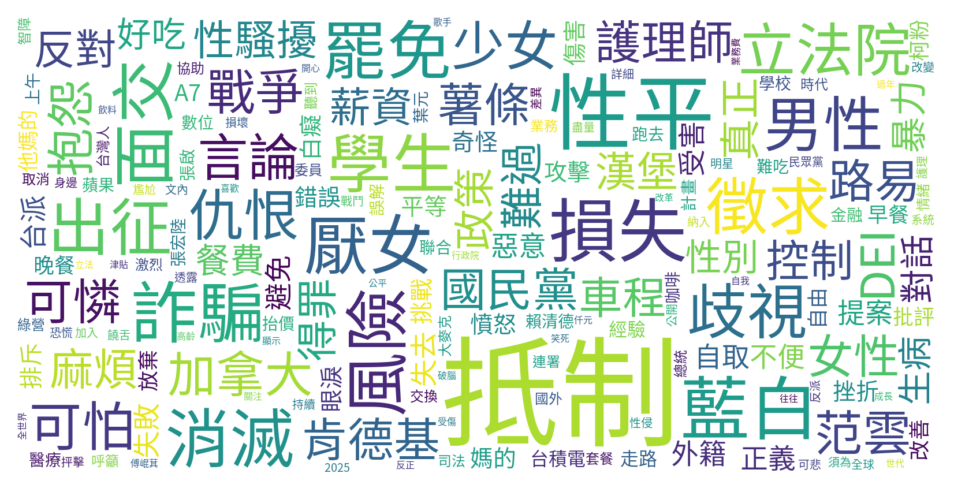

In [149]:
# wordcloud 的 input 是 dictionary
font_path = "raw_data/SourceHanSansTW-Regular.otf"  # 中文字型路徑
wc_dict = dict(zip(word_count_count['word'], word_count_count['size']))
cloud = WordCloud(scale = 4, max_words=200, background_color="white", font_path=font_path)
cloud.generate_from_frequencies(wc_dict)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

關鍵字出現了「抵制」的關鍵字，可能是在說明前陣子少女打工被性騷擾的事件

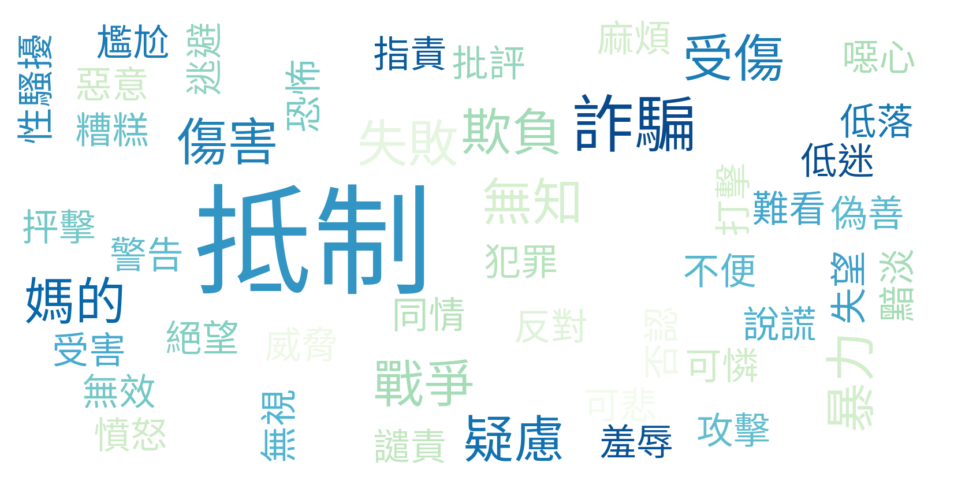

In [150]:
date = "2025-01-01"
end_date = "2025-03-13"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & ( # 時間區間
    ptt_liwc_df_revise['sentiment_class'] == "負向")  & ( # 負面文章
    ptt_liwc_df_revise['artContent'].str.contains('抵制')) & ( # 內文包含雞腿排
    ptt_liwc_df_revise["sentiments"] == "negative") # 負面情緒字

ptt_df_wc = ptt_liwc_df_revise.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()

# wordcloud 的 input 是 dictionary
cloud = WordCloud(scale = 4, max_words=200, background_color="white", font_path=font_path, colormap="GnBu")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(
    cloud,
    interpolation="bilinear"
)
plt.axis("off")
plt.show()

利用「性騷擾」去查看原文內容

In [151]:
date = "2025-01-01"
end_date = "2025-03-13"
mask = (sent_df['artDate'] >= pd.Timestamp(date).date()) & (
    sent_df['artDate'] <= pd.Timestamp(end_date).date()) & (
    sent_df['sentiment_class'] == "負向") & (
    sent_df['artContent'].str.contains('抵制')) & (
    sent_df['sentence'].str.contains('性騷擾')) # 包含「性騷擾」的句子

df_ = sent_df.loc[mask, ["artDate", "artContent", "sentence"]]
index_list = df_.index.tolist()


# 取得前後各5筆的索引 => 目的為查看包含該詞彙句子的上下文
surrounding_indices = []
for index in index_list:
    surrounding_indices.extend(range(index - 5, index + 6))

# 去除重複的索引，並確保不超出範圍
surrounding_indices = list(set(filter(lambda x: x >= 0 and x < len(sent_df), surrounding_indices)))

# 依據索引取得相應的資料
result_df = sent_df.iloc[surrounding_indices].sort_index()
result_df[['artTitle', 'sentence', 'sentiment_class']]

artTitle                sentence sentiment_class
11388  [新聞]金M招牌黯淡麥當勞叔叔笑不出來董事長  針對全台25萬名員工進行大規模一對一關懷訪談              負向
11389  [新聞]金M招牌黯淡麥當勞叔叔笑不出來董事長            全面檢視職場性平是否落實              負向
11390  [新聞]金M招牌黯淡麥當勞叔叔笑不出來董事長                超過23萬人回饋              負向
11391  [新聞]金M招牌黯淡麥當勞叔叔笑不出來董事長        赫然發現一件可能以前都不知道的事              負向
11392  [新聞]金M招牌黯淡麥當勞叔叔笑不出來董事長                  部分員工透露              負向
11393  [新聞]金M招牌黯淡麥當勞叔叔笑不出來董事長           確實遭遇過性騷擾或職場暴力              負向
11394  [新聞]金M招牌黯淡麥當勞叔叔笑不出來董事長      卻未曾想要利用任何溝通管道申訴或反映              負向
11395  [新聞]金M招牌黯淡麥當勞叔叔笑不出來董事長               麥當勞正視訪談結果              負向
11396  [新聞]金M招牌黯淡麥當勞叔叔笑不出來董事長              立即根據員工特別需求              負向
11397  [新聞]金M招牌黯淡麥當勞叔叔笑不出來董事長      後續規劃更完善的關懷協助李昌霖不諱言              負向
11398  [新聞]金M招牌黯淡麥當勞叔叔笑不出來董事長             同事有疑慮粉絲也失望了              負向

赫然發現一件可能以前都不知道的事，部分員工透露，確實遭遇過性騷擾或職場暴力，卻未曾想要利用任何溝通管道申訴或反映。
- 可以推斷出麥當勞性侵議題，有很多員工受過傷害，卻不敢發聲

## 3. 情緒分析 （二）

### 3.1 安裝CKIP

In [44]:
data_utils.download_data_gdown("./")  # 下載ckip model

Downloading...
From (original): https://drive.google.com/uc?id=1efHsY16pxK0lBD2gYCgCTnv1Swstq771
From (redirected): https://drive.google.com/uc?id=1efHsY16pxK0lBD2gYCgCTnv1Swstq771&confirm=t&uuid=fb21752a-31be-4e64-8884-94c7a371439f
To: /home/tingyu/McDonald/data.zip
100%|██████████| 1.88G/1.88G [00:55<00:00, 33.6MB/s]


In [45]:
# 將三份工具的模型路徑指向我們剛才下載的檔案「data」
ws = WS("./data")
pos = POS("./data")
ner = NER("./data")

/opt/miniconda3/envs/TA/lib/python3.11/site-packages/ckiptagger/model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
2025-03-23 20:25:57.537263: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-03-23 20:25:57.537294: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: hadoop18
2025-03-23 20:25:57.537301: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: hadoop18
2025-03-23 20:25:57.537412: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.183.1
2025-03-23 20:25:57.537432: I external/local_xla/xla/stream_executor/c

### 3.1 將抓取結果用CKIP進行處理
資料來源：
+ 工作流程平台蒐集PTT 速食板(fastfood)文章
+ 關鍵字:「麥當勞」(1000筆)
+ 時間: 2022-06-21 ~ 2025-03-21

In [46]:
## 讀取文章
df = pd.read_csv("./raw_data/ptt_mcdonalds.csv")
df.head()

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/fastfood/M.1742555480.A...   
1          2  https://www.ptt.cc/bbs/fastfood/M.1742097993.A...   
2          3  https://www.ptt.cc/bbs/fastfood/M.1742012365.A...   
3          4  https://www.ptt.cc/bbs/fastfood/M.1741948717.A...   
4          5  https://www.ptt.cc/bbs/fastfood/M.1741870732.A...   

                     artTitle              artDate    artPoster artCatagory  \
0   [情報] 日本麥當勞3/21起兒童餐玩具-哆啦A夢  2025-03-21 19:11:17         msun    fastfood   
1            [商品] 麥當勞 草莓優格雙餡派  2025-03-16 12:06:31  jasonsinica    fastfood   
2       [商品] 麥當勞 蛇年開春 F40雙人早餐  2025-03-15 12:19:23  jasonsinica    fastfood   
3  [新聞] 麥當勞甜心卡2025今開賣！常見問題、注意  2025-03-14 18:38:34         JQK2    fastfood   
4           [問題] 麥當勞監視器影像保留時間  2025-03-13 20:58:50   caronms144    fastfood   

                                          artContent  \
0  日本麥當勞3/21起兒童餐玩具-哆啦A夢\n\n30秒CM\nhttps://www.you...   
1  《廠商/分店別》： 麥當勞 苗栗店\n\n《商品名稱》：草莓優格雙餡派\n\n《內容物》：h...   
2  《廠商/分店別》： 麥當勞 苗栗店\n\n《商品名稱》： 蛇年開春 F40 雙人早餐\n\n...   
3  麥當勞甜心卡2025今開賣！常見問題、注意事項曝　草莓冰炫風上市\n\n記者蕭涵云/綜合報導...   
4  各位大大晚安\n想請問麥當勞的監視器影像會保留多久呢，不知道在這個版問對不對，主要是當天很確...   

                                          artComment            e_ip  \
0  [{'cmtStatus': '→', 'cmtPoster': 'Tsuyoi', 'cm...    1.160.206.25   
1  [{'cmtStatus': '推', 'cmtPoster': 'baiyutw', 'c...  111.246.194.68   
2  [{'cmtStatus': '→', 'cmtPoster': 'syensyens', ...  111.246.194.68   
3  [{'cmtStatus': '推', 'cmtPoster': 'siekensou000...   1.200.106.175   
4  [{'cmtStatus': '推', 'cmtPoster': 'a29022792', ...   59.28.152.107   

          insertedDate dataSource  
0  2025-03-23 08:04:47        ptt  
1  2025-03-23 08:04:48        ptt  
2  2025-03-23 08:04:50        ptt  
3  2025-03-23 08:04:52        ptt  
4  2025-03-23 08:04:53        ptt

定義文字清理的相關function

In [47]:
def Segmentation_Core(data, tokenizer):
    # 將所有的斷行字元配上 escape 以防失效
    regexPattern = '|'.join(map(re.escape, tokenizer))
    output_list = re.split(regexPattern, data)
    # 過濾空白行
    output_list = list(filter(None, output_list))
    return output_list

def Sentence_Segmentation(article, keep_digits=False, keep_alphabets=False):
    """ Sentence_Segmentation function 用於執行中文斷行任務

    順序如下：
    1. 去除(\\n)
    2. 去除特殊符號字元
    3. 保留數字
    4. 依照斷句字元進行斷句全形的分號、逗號、句號、問號以及驚嘆號
    5. 避免空白斷句結果

    Args:
        article(string): 欲斷行之文章內容
        keep_digits(Boolean): 決定是否保留數字於斷行後的結果
        keep_alphabets(Boolean): 決定是否保留字母於斷行後的結果
    Returns:
        List [] 每個 element 就是一行
    """
    if not isinstance(article, str):
        article = str(article)
    sepical_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—一‘’‛“”„‟…‧﹏★→─]+'
    segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")


    paragraphs = list(filter(lambda x: re.sub(r'\s+','', x), article.split("\n")))
    # print(len(paragraphs))
    # print(paragraphs)

    result = []
    for paragraph in paragraphs:

        clean_paragraph = paragraph
        try:
            if not keep_digits:
                clean_paragraph = re.sub(r'\d*\.?\d+','', clean_paragraph) #remove space & digits
            if not keep_alphabets:
                clean_paragraph = re.sub('[a-zA-Z]+', '', clean_paragraph)

            clean_paragraph = re.sub(r'[\s]+','', clean_paragraph) #remove space


            clean_paragraph = re.sub(sepical_symbols,'',clean_paragraph)

        except:
            return "error"

        res = Segmentation_Core(clean_paragraph, segmentation_used_note)
        res = [s for s in res if len(s.strip()) > 1 and re.search(r'[\u4e00-\u9fff]', s)]

        if res:
            result.append(res)


    return result

CKIP 處理相關function

In [48]:
# 自定義辭典
with open('./dict/user_dict.txt') as f:
    lines = f.read().splitlines()

dict = {k.split()[0]: k.split()[1] for v, k in enumerate(lines)}
dictionary2 = construct_dictionary(dict)
print(dictionary2)

[(2, {'襄理': 500.0}), (3, {'大麥克': 500.0, '麥香鷄': 500.0, '麥香魚': 500.0}), (4, {'重北一店': 500.0, '優惠活動': 500.0, '超值全餐': 500.0, '極選系列': 500.0, '豬肉蛋堡': 500.0, '藜麥沙拉': 500.0}), (5, {'妨害性自主': 500.0, '獵人公關品': 500.0, '青蔬滿福堡': 500.0, '勁辣鷄腿堡': 500.0, '雙層麥香鷄': 500.0}), (6, {'麥當勞分享盒': 500.0, '四盎司牛肉堡': 500.0, '藜麥烤鷄沙拉': 500.0, '藜麥鱈魚沙拉': 500.0}), (7, {'豬肉滿福堡加蛋': 500.0, '雙層牛肉吉事堡': 500.0, '蕈菇主廚鷄腿堡': 500.0, '藜麥辣脆鷄沙拉': 500.0}), (8, {'蕈菇安格斯牛肉堡': 500.0}), (9, {'帕瑪森安格斯牛肉堡': 500.0})]


In [49]:
from tqdm import tqdm

def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
    # print("\nPOS: ", end="\u3000")
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id, word, pos])
    # print(f"{word}({pos})", end="\u3000")
    return tokens

def get_ner(post_id, entity_sentence):
    entities = []
    # print("\nNER:___________ ")
    for entity in sorted(entity_sentence): # token level
        entities.append([post_id, entity[3], entity[2]])
    return entities

def get_nlp_result(data_df):
    start = time.time()

    pos_list = []
    entity_list = []
    sentence_list = []

    # 遍歷 dataframe 的每筆資料
    for index, row in tqdm(data_df.iterrows(), total=len(data_df)):
    # print(f"\ndocument {index}")

        # 資料清理 ＆ 斷句
        tmp = Sentence_Segmentation(row['artContent'], keep_digits=True, keep_alphabets=True)
        flat_list = [item for sublist in tmp for item in sublist]

        # ckip
        word_sentence_list = ws(flat_list, coerce_dictionary = dictionary2)
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

        # 遍歷該 document 中的每一個句子
        for i, sentence in enumerate(flat_list):
            # print(f"sentence {i}: {sentence}")
            sentence_list.append([row['system_id'], sentence])
            temp_tokens = get_pos(row['system_id'], word_sentence_list[i], pos_sentence_list[i])
            temp_entites = get_ner(row['system_id'], entity_sentence_list[i])

            pos_list.append(temp_tokens)
            if len(temp_entites) != 0:
                entity_list.append(temp_entites)

    pos_flat = [item for sublist in pos_list for item in sublist]
    entity_flat = [item for sublist in entity_list for item in sublist]

    pos_table = pd.DataFrame(data=pos_flat,
                    columns=['system_id','word','pos'])

    entity_table = pd.DataFrame(data=entity_flat,
                        columns=['system_id','word','ner'])

    sentence_table = pd.DataFrame(data=sentence_list,
                    columns=['system_id','sentence'])

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, entity_table, sentence_table

In [50]:
# 看看 tmp 和 flat_list 有什麼差別
tmp = Sentence_Segmentation(df['artContent'][0])
flat_list = [item for sublist in tmp for item in sublist]
print(tmp[:5])
print(flat_list[:5])

[['日本麥當勞/起兒童餐玩具哆啦夢'], ['介紹影片'], ['第彈/金/木'], ['第彈/金/木'], ['第彈/金']]
['日本麥當勞/起兒童餐玩具哆啦夢', '介紹影片', '第彈/金/木', '第彈/金/木', '第彈/金']


In [51]:
pos_table, entity_table, sentence_table = get_nlp_result(df)

100%|██████████| 1000/1000 [06:20<00:00,  2.62it/s]


time costing: 381.06342697143555


+ 欄位名稱介紹
    + pos_table 欄位:
        + system_id : ptt 貼文id
        + word: 原始斷詞
        + pos : part-of-speech,詞性
    + entity_table 欄位:
        + system_id : ptt 貼文id
        + word: 原始斷詞
        + ner: 命名實體
    + sentence_table 欄位:
        + system_id : ptt 貼文id
        + text: 原始斷句

In [52]:
pos_table.head() # word pos 列表

system_id  word pos
0          1    日本  Nc
1          1   麥當勞  Nc
2          1  3/21  Nd
3          1     起  Ng
4          1   兒童餐  Na

In [53]:
entity_table.head() # word entity 列表

system_id  word      ner
0          1    日本      GPE
1          1   麥當勞      ORG
2          1  3/21  PRODUCT
3          1   30秒     TIME
4          1    第１  ORDINAL

In [55]:
sentence_table.head()

system_id             sentence
0          1  日本麥當勞3/21起兒童餐玩具哆啦A夢
1          1                30秒CM
2          1                 介紹影片
3          1        第１彈3/21金3/27木
4          1         第２彈3/28金4/3木

In [56]:
# 檢查筆數
print(f"total posts numbers: {len(pos_table['system_id'].unique())}") # 1628篇文
print(f"posts have NER: {len(entity_table['system_id'].unique())}") # 1620篇有抓到ner

total posts numbers: 1000
posts have NER: 974


In [57]:
# 將文章存成csv
pos_table.to_csv('raw_data/zh/pos_table_mcdonald.csv', index = False)
entity_table.to_csv('raw_data/zh/entity_table_mcdonald.csv', index = False)
sentence_table.to_csv('raw_data/zh/sentence_table_mcdonald.csv', index = False)

### 3.2 探索分析 - NER

In [58]:
# 讀取已經執行完畢的結果
pos_table = pd.read_csv("raw_data/zh/pos_table_mcdonald.csv")
entity_table = pd.read_csv("raw_data/zh/entity_table_mcdonald.csv")
sentence_table = pd.read_csv("raw_data/zh/sentence_table_mcdonald.csv")

### NER 種類分析
查看標註這個文集後辨識出哪一些實體種類<br>
名詞對應: https://ckip.iis.sinica.edu.tw/service/corenlp/ （左上角的標記列表）

In [59]:
entity_table['ner'].unique()

array(['GPE', 'ORG', 'PRODUCT', 'TIME', 'ORDINAL', 'CARDINAL', 'MONEY',
       'DATE', 'PERSON', 'FAC', 'NORP', 'WORK_OF_ART', 'QUANTITY', 'LOC',
       'EVENT', 'LAW', 'LANGUAGE', 'PERCENT'], dtype=object)

In [60]:
ner_count = entity_table.groupby(['ner'])['ner'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(10)
ner_count

ner  count
11       ORG   4146
4        GPE   4028
0   CARDINAL   3358
1       DATE   2321
8      MONEY   1485
13    PERSON   1341
14   PRODUCT    675
16      TIME    584
7        LOC    485
3        FAC    420

Text(0.5, 0, 'Frequency')

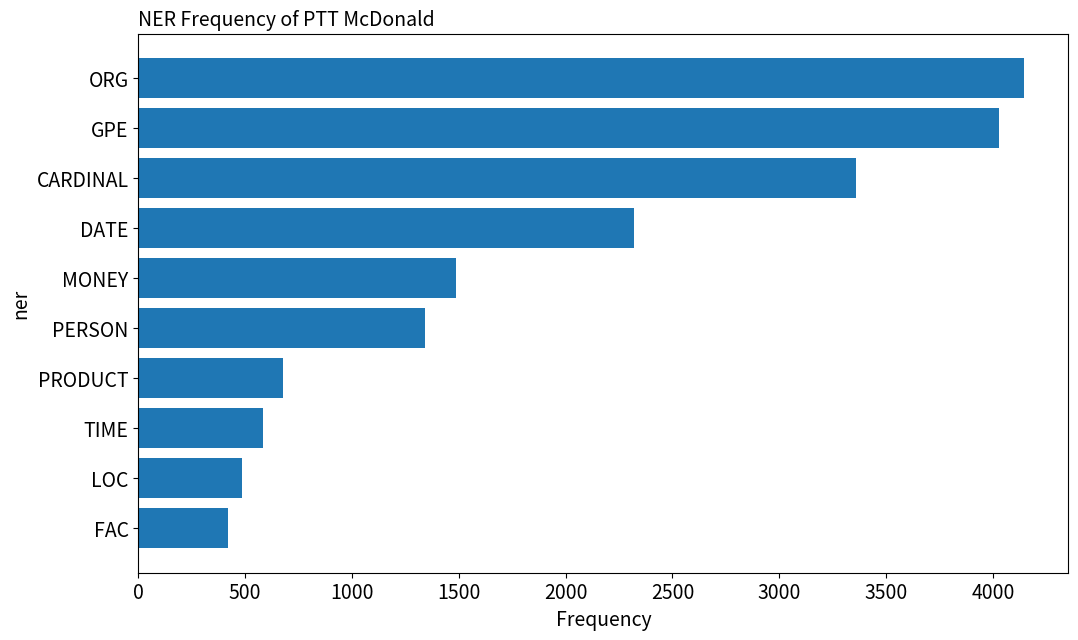

In [61]:
ner = ner_count['ner']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(ner, count)
ax.invert_yaxis()
ax.set_title('NER Frequency of PTT McDonald',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
# fig.show()

### 涉及到的民族、宗教、政治團體(NORP)

Text(0.5, 0, 'Word Frequency')

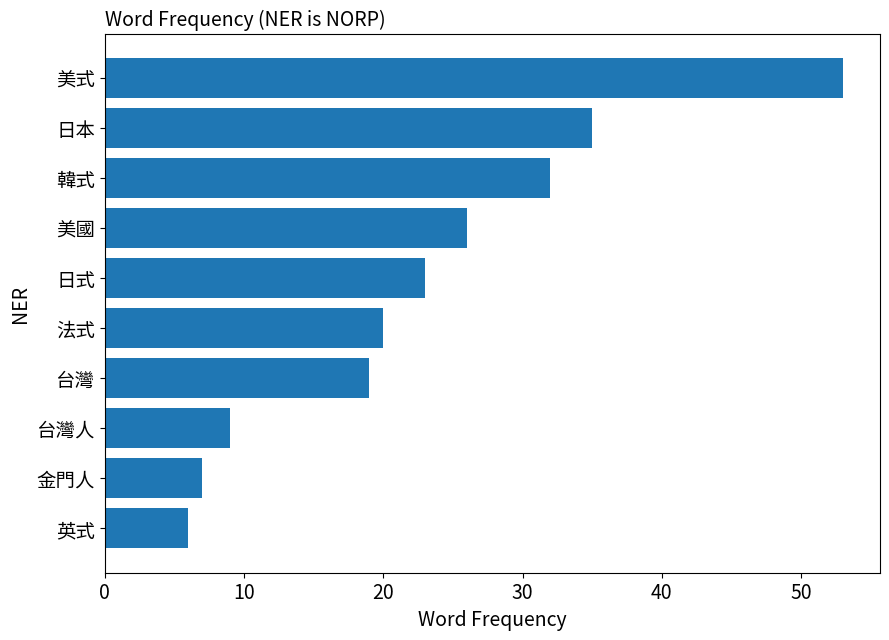

In [62]:
# 篩選ner為NORP的資料
l_noun = ["NORP"]
NORP = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = NORP.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is NORP)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
# fig.show()

麥當勞是全球的連鎖店，可以看出日本麥當勞是討論最多的話題，有可能是因為很常與動漫聯名，並且日本麥當勞兒童餐「家家酒玩具」預計在2025 年2 月底至3 月中旬推出，可能也是大家討論的議題之一。

### 涉及到的組織(ORG)

Text(0.5, 0, 'Word Frequency')

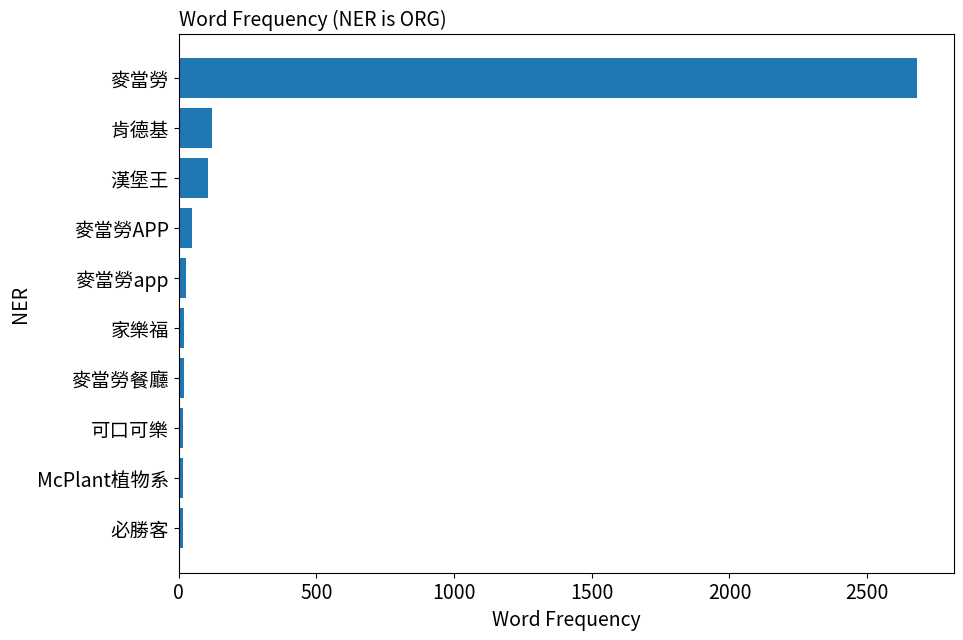

In [63]:
# 篩選ner為ORG的資料
l_noun = ["ORG"]
ORG = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = ORG.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORG)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
# fig.show()

除了麥當勞之外，還有同樣是速食餐廳也有被提及，像是「肯德基」、「漢堡王」、「摩斯漢堡」。

### 涉及到的人物(PERSON)

Text(0.5, 0, 'Word Frequency')

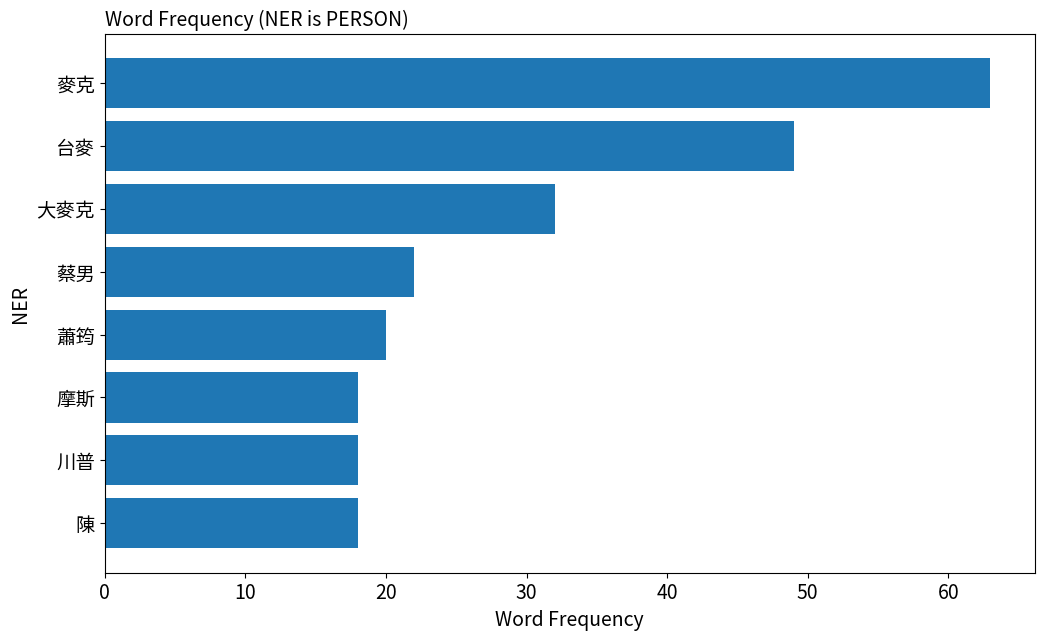

In [64]:
# 篩選ner為PERSON的資料
l_noun = ["PERSON"]
PERSON = entity_table[entity_table.ner.isin(l_noun)]

# 計算每個名詞提到的次數，選出前8個
ner_count = PERSON.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(8).reset_index()

# 設定中文字形
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is PERSON)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
# fig.show()

- 美國總統當選人川普熱愛麥當勞成痴，不但在競選期間跑去麥當勞店面打工，平時也會享用他鍾愛的「川普套餐」，甚至分享給內閣首長和朋友。


In [65]:
keyword_list = ['日本']
shu_selected = df[df['artContent'].str.contains('|'.join(keyword_list), regex=True, na=False)]
print(f"{' '.join(keyword_list)}：{shu_selected.shape[0]}篇相關貼文")
shu_selected.head()

日本：58篇相關貼文


system_id                                             artUrl  \
0           1  https://www.ptt.cc/bbs/fastfood/M.1742555480.A...   
27         28  https://www.ptt.cc/bbs/fastfood/M.1738384427.A...   
60         61  https://www.ptt.cc/bbs/fastfood/M.1733732355.A...   
61         62  https://www.ptt.cc/bbs/fastfood/M.1733725363.A...   
79         80  https://www.ptt.cc/bbs/fastfood/M.1731941194.A...   

                          artTitle              artDate     artPoster  \
0        [情報] 日本麥當勞3/21起兒童餐玩具-哆啦A夢  2025-03-21 19:11:17          msun   
27        [新聞] 石垣島麥當勞傳歇業！ 與那國島居民：最  2025-02-01 12:33:44          JQK2   
60         [新聞] 麥當勞「明太子鮭魚系列」升級回歸！加  2024-12-09 16:19:12  turndown4wat   
61  [新聞] 麥當勞「陶瓷碗盤組」限量開賣！明太子鮭魚系列也登場  2024-12-09 14:22:41      kof70380   
79          [問題] 麥當勞厚鬆餅和普通鬆餅味道一樣嗎?  2024-11-18 22:46:32         logen   

   artCatagory                                         artContent  \
0     fastfood  日本麥當勞3/21起兒童餐玩具-哆啦A夢\n\n30秒CM\nhttps://www.you...   
27    fastfood  石垣島麥當勞傳歇業！ 與那國島居民：最近的分店在台灣\n\n2025/01/30 20:17...   
60    fastfood  麥當勞「明太子鮭魚系列」升級回歸！加碼吃全新藍莓卡士達雙餡派\n\nhttps://cdn2...   
61    fastfood  來源：\n\nhttps://udn.com/news/story/7270/8413017...   
79    fastfood  沒有吃到過那個厚鬆餅堡\n不知道吃過的能不能說說\n去除楓糖味外到底和平常早餐的55元鬆餅口...   

                                           artComment             e_ip  \
0   [{'cmtStatus': '→', 'cmtPoster': 'Tsuyoi', 'cm...     1.160.206.25   
27  [{'cmtStatus': '推', 'cmtPoster': 'UD305', 'cmt...  210.243.229.170   
60  [{'cmtStatus': '推', 'cmtPoster': 'wcpsgb', 'cm...  114.136.142.254   
61  [{'cmtStatus': '推', 'cmtPoster': 'lioucat', 'c...      111.242.9.4   
79  [{'cmtStatus': '噓', 'cmtPoster': 'Payne22', 'c...   220.135.50.221   

           insertedDate dataSource  
0   2025-03-23 08:04:47        ptt  
27  2025-03-23 08:05:32        ptt  
60  2025-03-23 08:06:32        ptt  
61  2025-03-23 08:06:35        ptt  
79  2025-03-23 08:07:07        ptt

### 3.3 探索分析 - POS

#### POS 種類分析
查看辨識出哪幾種POS<br>
名詞對應: https://ckip.iis.sinica.edu.tw/service/corenlp/ （左上角的標記列表）

In [66]:
pos_table['pos'].unique()

array(['Nc', 'Nd', 'Ng', 'Na', 'Nb', 'FW', 'Neu', 'Nf', 'VE', 'VC',
       'Neqa', 'VA', 'VH', 'DE', 'COMMACATEGORY', 'D', 'Dfa', 'VD', 'VJ',
       'Cbb', 'Nep', 'Nh', 'SHI', 'A', 'VL', 'VK', 'Di', 'V_2', 'VG',
       'VCL', 'T', 'Ncd', 'VF', 'P', 'Nes', 'Caa', 'VHC', 'Nv', 'Cab',
       'VI', 'Da', 'Neqb', 'VB', 'Dk', 'Dfb', 'I', 'COLONCATEGORY', 'Cba',
       'VAC', 'PARENTHESISCATEGORY', 'PERIODCATEGORY', 'DM'], dtype=object)

In [67]:
pos_filter = pos_table[~pos_table.pos.isin(['COMMACATEGORY', 'PARENTHESISCATEGORY', 'PERIODCATEGORY', 'COLONCATEGORY'])]

pos_count = pos_filter.groupby(['pos'])['pos'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(12)
pos_count

pos  count
15   Na  43107
5     D  20715
35   VC  15479
17   Nc  14142
41   VH  11084
24  Neu  10814
13   FW  10497
25   Nf   7323
6    DE   7292
29    P   5991
19   Nd   5712
38   VE   4295

#### POS 常見詞性列表
+ Na: 普通名詞
+ D: 副詞
+ VC: 動作及物動詞
+ Nb: 專有名詞
+ FW: 外文
+ VH: 狀態不及物動詞
+ Nh: 代名詞
+ DE: 的之得地
+ P: 介詞
+ VA: 動作不及物動詞
+ T: 語助詞
+ SHI: 是

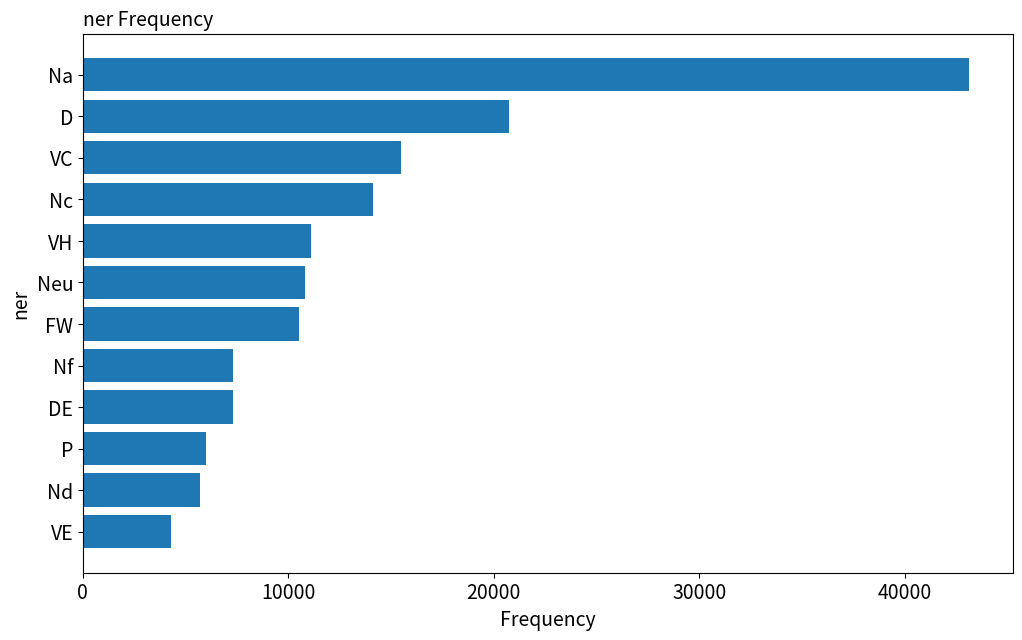

In [68]:
pos = pos_count['pos']
count = pos_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(pos, count)
ax.invert_yaxis()
ax.set_title('ner Frequency',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

### 涉及到的名詞(Noun)
+ 我們可以找出談論麥當勞大部分討論到的名詞，探索大家的關注焦點。
+ 名詞可以分為「Na: 普通名詞」、「Nb: 專有名詞」等

In [69]:
# 篩選pos為專有名詞的資料
l_noun = ["Nb"] #,"Na"
noun = pos_table[pos_table.pos.isin(l_noun)]

# 計算每個名詞提到的次數，選出前15個
noun_count = noun[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
noun_count.head(10)

word  count
953   麥克    247
342  大麥克    180
614  漢堡王    127
414  帕瑪森     69
134   中山     64
365  家樂福     47
138   中正     44
856   金迎     41
473   摩斯     33
915   雪碧     29

In [70]:
# 設定文字雲中文字體路徑
font_path = "raw_data/SourceHanSansTW-Regular.otf"

# 設定圖的字體大小
plt.rcParams['font.size'] = 14

# 1) 將字體檔案加入到 matplotlib 的字體庫
fm.fontManager.addfont(font_path)

# 2) 建立 FontProperties 物件
fprop = fm.FontProperties(fname=font_path)

# 3) 設定整體的 font.family 為此字體
plt.rcParams['font.family'] = fprop.get_name()

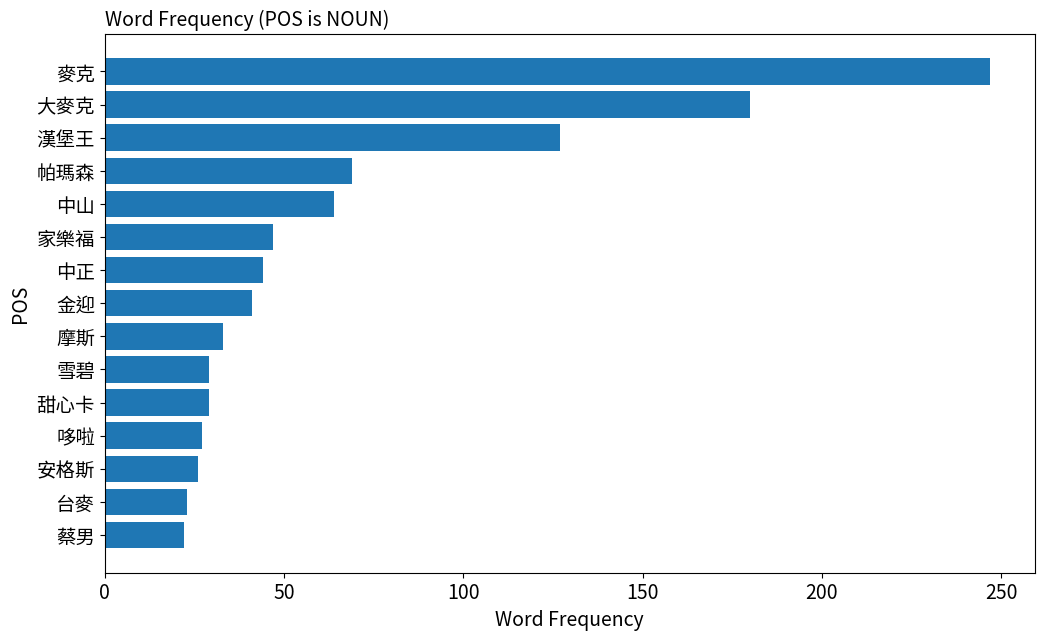

In [71]:
# 設定中文字形
word = noun_count['word']
count = noun_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is NOUN)',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

可以看出大家很常討論的品項是「大麥克」，和「甜心卡」是麥當勞常客會買的商品。

### 涉及到的動詞(VERB)
+ 我們可以找出談論麥當勞時大部分討論到的動詞，探索相關行為。
+ VC: 動作及物動詞、VH: 狀態不及物動詞、VA: 動作不及物動詞

In [72]:
l_verb = ["VC"] # ,"VH","VA"
verb = pos_table[pos_table.pos.isin(l_verb)] # 選取特定詞性
verb = verb[verb['word'].map(len) > 1] # 把長度為1的字去除掉

verb_count = verb[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
verb_count

word  count
740    推出    348
43     使用    289
1277   編輯    236
797    搭配    195
322    單點    178
105    兌換    159
1513   購買    117
1622   選擇    105
267    吃到    101
634    拿到     95
498    引述     89
1112   牽絲     82
946    服務     79
1606   遇到     75
381    外帶     70

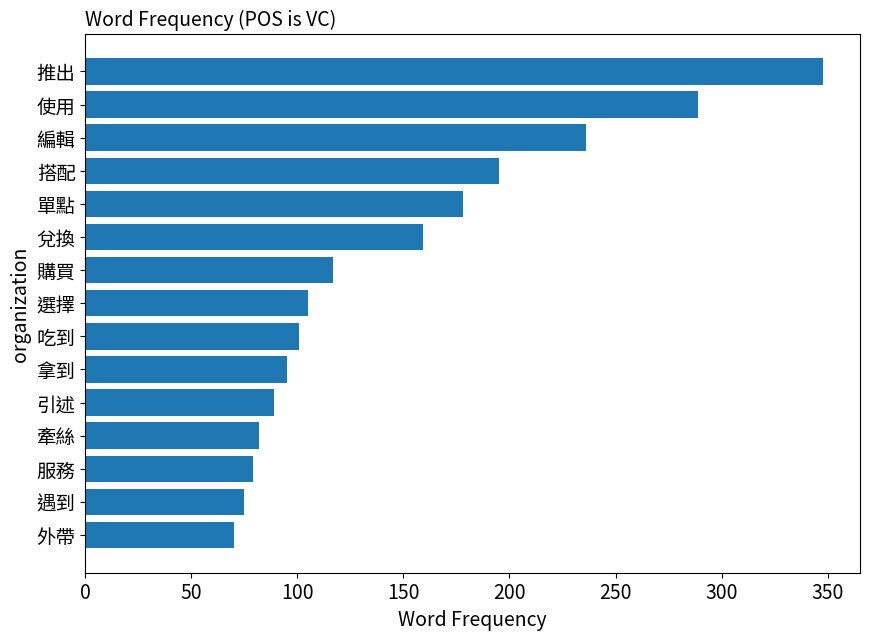

In [73]:
word = verb_count['word']
count = verb_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is VC)',loc ='left', size = 14)
ax.set_ylabel('organization', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

可以看到「推出」提及率很高，也可以聯想到麥當勞推出新產品時會被廣泛討論，試吃心得。

## 4. 利用SnowNLP進行情緒分析

+ SnowNLP 針對中文設計，可以提取句子的情緒分類
+ 使用文件分類法，套件已預先用文集訓練模型以判斷情緒
+ 情緒值在 0~1之間，代表負面到正面
+ 官方github: https://github.com/isnowfy/snownlp

In [74]:
sentence_table = pd.read_csv("raw_data/zh/sentence_table_mcdonald.csv") #匯資料

sentiment_date = pd.merge(sentence_table,shu_selected[['system_id','artDate','dataSource']],on='system_id',how='left').dropna()

sentiment_date.head()

system_id             sentence              artDate dataSource
0          1  日本麥當勞3/21起兒童餐玩具哆啦A夢  2025-03-21 19:11:17        ptt
1          1                30秒CM  2025-03-21 19:11:17        ptt
2          1                 介紹影片  2025-03-21 19:11:17        ptt
3          1        第１彈3/21金3/27木  2025-03-21 19:11:17        ptt
4          1         第２彈3/28金4/3木  2025-03-21 19:11:17        ptt

In [75]:
from snownlp import SnowNLP
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# 幫每句話加上情緒分數
sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
sentiment_date.head(3)

system_id             sentence              artDate dataSource  \
0          1  日本麥當勞3/21起兒童餐玩具哆啦A夢  2025-03-21 19:11:17        ptt   
1          1                30秒CM  2025-03-21 19:11:17        ptt   
2          1                 介紹影片  2025-03-21 19:11:17        ptt   

   sentimentValue  
0        0.535717  
1        0.541183  
2        0.816782

In [76]:
# 看一下情緒的分布
sentiment_date['sentimentValue'].describe()

count    1.455000e+03
mean     3.651663e-01
std      3.244638e-01
min      2.719653e-07
25%      5.559778e-02
50%      2.810735e-01
75%      6.166894e-01
max      9.998876e-01
Name: sentimentValue, dtype: float64

<Axes: >

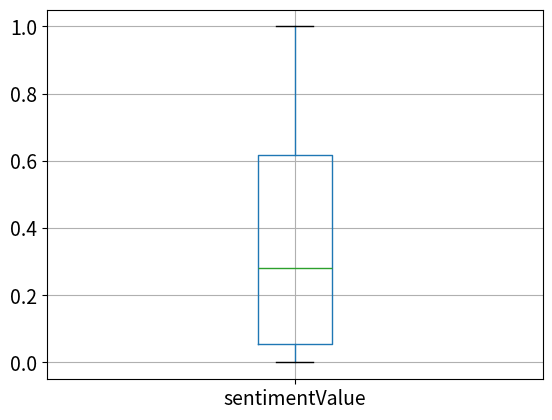

In [77]:
# 情緒分布的盒狀圖
boxplot = sentiment_date.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

將每個月的情緒分數取平均，並轉換時間格式為年月

In [78]:
sent_date = sentiment_date.copy()
sent_date['artDate'] =  pd.to_datetime(sentiment_date['artDate']).dt.to_period('M')

sentiment_count = sent_date.groupby(['artDate'])['sentimentValue'].mean().reset_index()
sentiment_count

artDate  sentimentValue
0   2022-08        0.382219
1   2022-09        0.330043
2   2022-10        0.427779
3   2022-11        0.299282
4   2022-12        0.330339
5   2023-01        0.307932
6   2023-02        0.297645
7   2023-03        0.356036
8   2023-04        0.436311
9   2023-05        0.397656
10  2023-06        0.225708
11  2023-07        0.322964
12  2023-09        0.321892
13  2023-10        0.406247
14  2023-11        0.348905
15  2023-12        0.365488
16  2024-01        0.428812
17  2024-02        0.449821
18  2024-03        0.382056
19  2024-04        0.399394
20  2024-05        0.412095
21  2024-07        0.396184
22  2024-09        0.516566
23  2024-11        0.348593
24  2024-12        0.359948
25  2025-02        0.319105
26  2025-03        0.531685

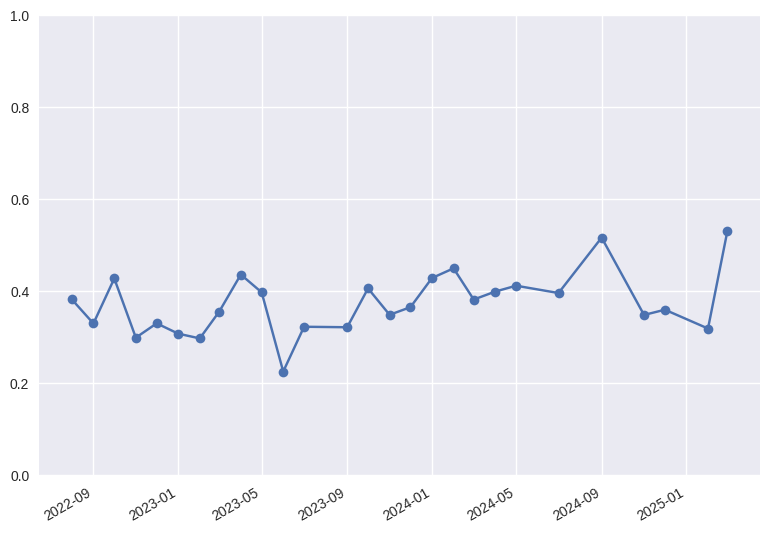

In [79]:
# 平均情緒分數時間趨勢
months = [period.to_timestamp() for period in sentiment_count['artDate']]   # 將 PeriodIndex 中的每個 Period 物件轉換為對應的 datetime 物件
y = sentiment_count['sentimentValue']

plt.style.use('seaborn-v0_8')

plt.plot_date(months, y, linestyle='solid')
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.ylim(0, 1)

plt.show()

### 詞彙探索
從上圖中可以發現 2024年9月 的情緒分數相對高，我們把這個月的正面句子挑出來看看他們都用甚麼詞。

In [80]:
# 篩時間
filter_sentiment = sent_date[sent_date['artDate']=='2024-09']
filter_sentiment = filter_sentiment.loc[filter_sentiment['sentimentValue'] > 0.7]

filter_sentiment.head()

system_id                  sentence  artDate dataSource  sentimentValue
2993        147               黃豆粉剛好中和紅豆甜味  2024-09        ptt        0.816590
2995        147              布丁卡士達奶昔就中規中矩  2024-09        ptt        0.996975
3003        147  對，是Aeon的美食街，不知道為什麼開在隔壁XD  2024-09        ptt        0.704841

In [81]:
# 把時間分數和之前斷詞的 token table 做 join
pos_words = pd.merge(filter_sentiment,pos_table,on='system_id',how='left')
pos_words = pos_words[['system_id','sentimentValue','word']]
pos_words.head()

system_id  sentimentValue word
0        147         0.81659  商品圖
1        147         0.81659   實物
2        147         0.81659    是
3        147         0.81659  黃豆粉
4        147         0.81659   紅豆

In [82]:
# 篩選掉只有單個字元的結果
pos_words = pos_words[pos_words.apply(lambda x: len(x['word'])>1, axis=1)]

### 正面詞彙文字雲

In [83]:
# 自定停用字
with open('dict/stop_words.txt') as f:
    stop_words = f.read().splitlines()

print(stop_words[:20])

[',', '?', '、', '。', '“', '”', '《', '》', '！', '，', '：', '；', '？', '可否', '有無', '再', '本來', '是不是', '一個', '這種']


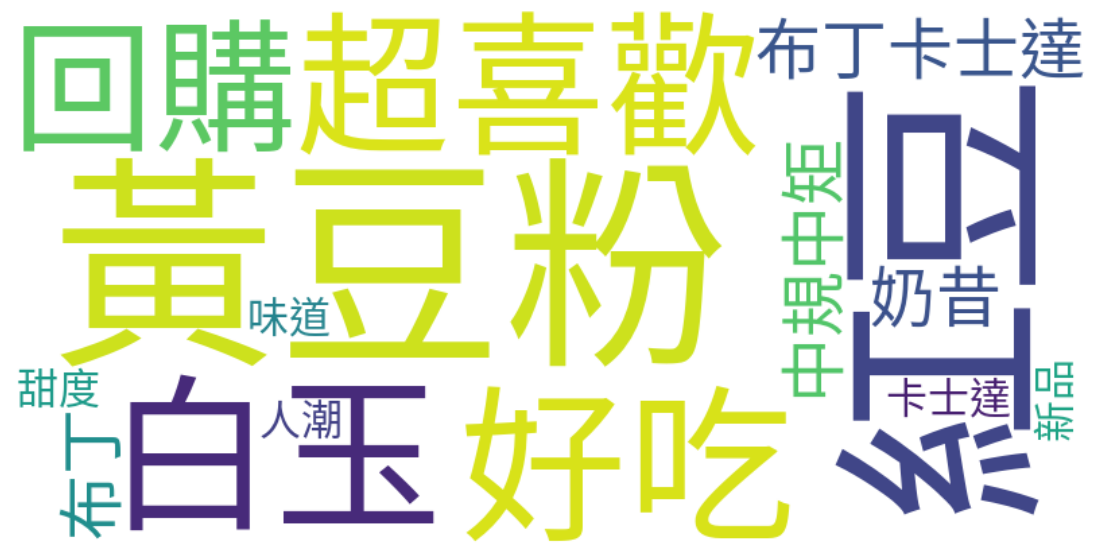

In [87]:
stop_words_pos = stop_words
stop_words_pos.extend(('麥當勞','sanajp', 'wwwpttcc', 'https', '網址', 'html', 'app', 'bbs',"整整","AC","XD","Aeon系列","意外","今天","日本","以為","差距",'Aeon', '美食街', 'fastfood', '商品圖','中姬', '中規','甜甜','系列', '商品圖', '出月', '編輯', '知道','喝完', '可怕','文章','肯德基',"白玉超",'甜味','小時','隔壁','M','拿到','配上','組合','中和','實物'))
stop_words_pos = set(stop_words_pos)

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words_pos,
                collocations=False,
                font_path=font_path,
                width=800,
                height = 400,
                max_words=100,
                background_color="white")

wordcloud.generate(' '.join(pos_words['word']))
# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

https://www.letsgojp.com/archives/687883

日本麥當勞在2024年9月推出新品「月見系列」，能看得出新產品廣受大家歡迎，其中包含了卡士達布丁奶昔、黃豆麻糬佐豆沙月見派。